# DQN training on our own gridworld

In [ ]:
! pip install gym tqdm torchvision

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd

import time
import gym

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tqdm import tqdm
import random

import torch.nn.functional as F
import torch 
from torch import nn
import torch.optim as optim
import torchvision.transforms as T
from PIL import Image
from collections import deque

import time

In [ ]:
env = gym.make('MountainCar-v0',render_mode="human")

rewards = []
max_episode = 1000
env.reset()
maxm = -99
env.render()
for i in range(max_episode):
    observation = env.reset()
    done        = False
    reward      = 0
    step=0
    while not done:
        action =  np.random.choice(env.action_space.n)
        obs, reward, done, truncated, info = env.step(action)
        print(step,obs)
        reward += reward
        maxm = max(maxm,obs[0])
        step+=1
        if step == 201:
            done = True
        
    print(maxm,step)
    # env.render()    
    rewards.append(reward)
print("Avg reward per episode :",sum(rewards)/ len(rewards))

# VIZDOOM SAMPLE

In [13]:
#!/usr/bin/env python3

#####################################################################
# This script presents how to read and use the sound buffer.
# This script stores a "basic_sounds.wav" file of recorded audio.
# Note: This requires scipy library
#####################################################################

import vizdoom as vzd

import os
from random import choice
import numpy as np
from scipy.io import wavfile
from time import sleep


if __name__ == "__main__":
    game = vzd.DoomGame()

    # Load config of the basic scenario
    game.load_config(os.path.join(vzd.scenarios_path, "simpler_basic.cfg"))

    # game.add_game_args('+snd_efx 0')

    # Turns on the audio buffer. (turned off by default)
    # If this is switched on, the audio will stop playing on device, even with game.set_sound_enabled(True)
    # Setting game.set_sound_enabled(True) is not required for audio buffer to work.
    AUDIO_BUFFER_ENABLED = True
    game.set_audio_buffer_enabled(AUDIO_BUFFER_ENABLED)

    # Set the sampling rate used in the observation window. Has to be one from:
    # - vzd.SamplingRate.SR_44100 (default)
    # - vzd.SamplingRate.SR_22050
    # - vzd.SamplingRate.SR_11025
    # Remember to also set audio saving code at the bottom to use same sampling rate!
    game.set_audio_sampling_rate(vzd.SamplingRate.SR_22050)

    # When using frameskip (`tics` parameter of the `make_actions` function),
    # we would only get the latest "frame" of audio (1/35 seconds).
    # With this function you can set how many last "frames" of audio will be stored in audio buffer.
    # Note that if you use larger frameskip than size of audio buffer you will lost some information about the audio.
    # If you use frameskip smaller than size of audio buffer, some audio information will overlap.
    frameskip = 4
    game.set_audio_buffer_size(frameskip)

    # This could fix "no audio in buffer" bug on Ubuntu 20.04.
    game.add_game_args("+snd_efx 0")

    # Initialize the game. Further configuration won't take any effect from now on.
    try:
        game.init()
    except Exception as e:
        print(
            "[ERROR] Could not launch ViZDoom. If you see an error above about BiquadFilter and gain,\n"
            "        try setting game.add_game_args('+snd_efx 0'). If that fails, see\n"
            "        https://github.com/mwydmuch/ViZDoom/pull/486"
        )
        exit(1)

    actions = [[True, False, False], [False, True, False], [False, False, True]]
    sleep_time = 1.0 / vzd.DEFAULT_TICRATE  # = 0.028

    episodes = 3
    audio_slices = []
    for i in range(episodes):
        print("Episode #" + str(i + 1))
        game.new_episode()
        while not game.is_episode_finished():

            # Gets the state
            state = game.get_state()

            audio_buffer = state.audio_buffer
            audio_slices.append(audio_buffer)

            # Makes a random action and get remember reward.
            r = game.make_action(choice(actions), frameskip)

            if not AUDIO_BUFFER_ENABLED:
                sleep(sleep_time * frameskip)            
    game.close()

    if AUDIO_BUFFER_ENABLED:
        # Check that we have audio (having no audio is a common bug, see
        # https://github.com/mwydmuch/ViZDoom/pull/486
        audio_data = np.concatenate(audio_slices, axis=0)
        if audio_data.max() == 0:
            print(
                "[WARNING] Audio buffers were full of silence. This is a common bug on e.g. Ubuntu 20.04\n"
                "          See https://github.com/mwydmuch/ViZDoom/pull/486\n"
                "          Two possible fixes:\n"
                "            1) Try setting game.add_game_args('+snd_efx 0'). This my disable some audio effects\n"
                "            2) Try installing a newer version of OpenAL Soft library, see https://github.com/mwydmuch/ViZDoom/pull/486#issuecomment-889389185"
            )
        # Save audio file
        wavfile.write("basic_sounds.wav", 22050, np.concatenate(audio_slices, axis=0))


Episode #1
Episode #2
Episode #3
[WARNING] Audio buffers were full of silence. This is a common bug on e.g. Ubuntu 20.04
          See https://github.com/mwydmuch/ViZDoom/pull/486
          Two possible fixes:
            1) Try setting game.add_game_args('+snd_efx 0'). This my disable some audio effects
            2) Try installing a newer version of OpenAL Soft library, see https://github.com/mwydmuch/ViZDoom/pull/486#issuecomment-889389185


In [30]:
class MCarVanillaDQN():
    def __init__(self, env, typ="dense"):
      self.env = env
      self.typ = typ
      self.max_episodes = 2000 #3000
      self.max_steps = 300
      self.gamma = 0.999
      self.epsilon = 1.0
      self.epsilon_min = 0.1
      self.epsilon_decay_lamda = self.epsilon_min**(1/self.max_episodes)
      self.target_update_counter = 0
      self.target_update_frequency = 2
      self.buffer_minibatch_size = 32
      self.replay_buffer_capacity=50000
      self.replay_buffer = deque([],maxlen=self.replay_buffer_capacity)
      self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(84, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])  
      env.reset()
      _, _, self.state_screen_h, self.state_screen_w = self.screen_preprocessor(self.env.render()).shape
      self.state_count = env.observation_space.shape[0]
      self.action_count = env.action_space.n
      self.target_dqn = DQN_FC(self.state_count, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      self.q_value_dqn = DQN_FC(self.state_count, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      # self.rms_optimizer = optim.RMSprop(self.q_value_dqn.parameters())#, lr=0.001)#, weight_decay=0.05)
      # self.loss_func = F.smooth_l1_loss
      self.rms_optimizer = optim.SGD(self.q_value_dqn.parameters(), lr=0.01)#optim.RMSprop(self.q_value_dqn.parameters(), lr=0.001)#, weight_decay=0.05)
      self.loss_func = F.mse_loss #F.smooth_l1_loss
      
      self.position_list = []
      self.timestep_list = []
      self.rewards_list = []
      self.epsilon_list = []
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.q_value_dqn.to(self.device)
      self.target_dqn.to(self.device)

      self.test_max_episodes = 10
      self.test_timestep_list = []
      self.test_rewards_list = []
      self.test_epsilon_list = []
      self.test_position_list = []
      self.trained_policy_path = "./mountain_car.pth"

    def initialize_buffer(self):
      for i in range(self.replay_buffer_capacity):
        self.env.reset()
        current_state = self.screen_preprocessor(self.env.render())
        done = False
        while not done:  
          current_action = self.choose_action(current_state.to(self.device))
          curr_obs, curr_reward, done, truncated, info = self.env.step(current_action.item())
          next_state = self.screen_preprocessor(self.env.render())

          self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
          current_state = next_state

    def screen_preprocessor(self,state_screen):
      def crop(variable,tw,th):
         c, h, w = variable.shape
         x1 = int(round((w - tw) / 2.))
         y1 = int(round((h - th) / 2.))
         return variable[:,y1:y1+th,x1:x1+tw]
      state_screen = state_screen.transpose((2,0,1))
      screen_c, screen_h, screen_w = state_screen.shape
      screen = self.resize(torch.from_numpy(state_screen))
#       screen = crop(screen, 60, 60)
      screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
      screen = torch.from_numpy(screen)
      return screen.unsqueeze(0)
    
    def choose_action(self, state, test=False):
      random_no = np.random.random()
      if self.epsilon > random_no and not test:
          return torch.tensor([[np.random.choice(self.action_count)]])
      else:
          return self.get_q_value_for_state(state)#.to(self.device))
    
    def get_q_value_for_state(self, state):
      q_values = self.q_value_dqn(state)
      return q_values.max(1)[1].view(1, 1)

    def eval(self):
      self.q_value_dqn.load_state_dict(torch.load(self.trained_policy_path))

      for episode in tqdm(range(0, self.test_max_episodes), unit='episodes'):
        obs = self.env.reset()[0]
        done = False
        reward_sum = 0
        steps = 0
        current_state = torch.from_numpy(obs).unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
          tt = time.time()

          current_action = self.choose_action(current_state, test=True).to(self.device)
          curr_obs, curr_reward, done, truncated, info = self.env.step(current_action.item())
          self.env.render()
          
          reward_sum += curr_reward
          next_state = torch.from_numpy(curr_obs).unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

          steps +=1
          
          current_state = next_state
          if steps==self.max_steps:
            done=True
        # self.test_position_list.append(current_state[0][0])
        self.update_target_net(episode)
            
        self.test_timestep_list.append(steps)
        self.test_rewards_list.append(reward_sum)


    def train(self):
      current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch = self.get_minibatch_from_replay_buffer()

      curr_q_value_list = self.q_value_dqn(current_state_batch.to(self.device)).gather(1, current_action_batch)
      next_q_value_list = self.target_dqn(next_state_batch.to(self.device))
      next_q_value_list = next_q_value_list.detach()
      exp_q_value_list = []
      for index in range(self.buffer_minibatch_size):
        if current_done_batch[index]:
          exp_q_value_list.append(current_reward_batch[index])
        else:
          exp_q_value_list.append((current_reward_batch[index] + max(next_q_value_list[index]) * self.gamma))

      exp_q_value_list = torch.tensor(exp_q_value_list).unsqueeze(1).to(self.device)

      self.rms_optimizer.zero_grad()
      loss = self.loss_func(curr_q_value_list, exp_q_value_list)
      loss.backward()
      for param in self.q_value_dqn.parameters():
          param.grad.data.clamp_(-1, 1)
      self.rms_optimizer.step()

      return loss.item()
      
    def learn(self):
      self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
      self.target_dqn.eval()
      
      running_loss=0
      loss=0
      self.tm = []
      self.tr = []
      for episode in tqdm(range(0, self.max_episodes), unit='episodes'):
        # with Profiler() as p:

        obs = self.env.reset()[0]
        done = False
        reward_sum = 0
        steps = 0
        current_screen = torch.from_numpy(obs).unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        current_state = current_screen - current_screen
        while not done:
          tt = time.time()
          current_state = current_state.to(self.device)
          current_action = self.choose_action(current_state).to(self.device)
          curr_obs, curr_reward, done, truncated, info = self.env.step(current_action.item())

          reward_sum += curr_reward #+current_state[0][0]
          prev_screen = current_screen
          current_screen = torch.from_numpy(curr_obs).unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
          next_state = current_screen-prev_screen
          self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
          current_state = next_state  
          t = time.time() 
          
          if len(self.replay_buffer) >= self.buffer_minibatch_size:       
            loss = self.train()
          self.tm.append(time.time()-t)
          steps +=1
          running_loss += loss
          current_state = next_state

          self.tr.append(time.time()-tt)
          if steps==self.max_steps:
            done=True

        self.update_target_net(episode)
            
        # self.position_list.append(current_state[0][0]) 
        self.timestep_list.append(steps)
        self.rewards_list.append(reward_sum)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.epsilon_decay_lamda)
      
        if episode % 10 == 9:
          # print(f"Buffer_size: {len(self.replay_buffer)}|Train_time:{sum(self.tm[-100:])/100}| Sub_t:{sum(self.tr[-100:])/100}")
          # print(f'[Episode: {episode+1}] - Steps: {steps+1} | Rewards: {reward_sum+1} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          print(f'[Episode: {episode+1}] - Steps: {sum(self.timestep_list[-10:])/10} | Rewards: {sum(self.rewards_list[-10:])/10} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          running_loss = 0.0
          # if sum(self.rewards_list[-100:])/100 >= 470:
          #   break
          # p.print()
        
    def update_target_net(self, episode):
       if episode % self.target_update_frequency == self.target_update_frequency-1:   
          self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
    
    def get_minibatch_from_replay_buffer(self):
      exp_batch = random.sample(self.replay_buffer, self.buffer_minibatch_size) #max(len(self.replay_buffer), self.buffer_minibatch_size))
      current_state_batch = torch.cat(tuple([exp[0] for exp in exp_batch]),dim=0).to(self.device)
      current_action_batch = torch.cat(tuple([exp[1] for exp in exp_batch]),dim=0).to(self.device)
      next_state_batch = torch.cat(tuple([exp[3] for exp in exp_batch]),dim=0).to(self.device)
      current_reward_batch = torch.tensor(tuple([exp[2] for exp in exp_batch])).to(self.device)
      current_done_batch = torch.tensor(tuple([exp[4] for exp in exp_batch])).to(self.device)
      return current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch
    
    def add_to_replay_buffer(self, experience):
       self.replay_buffer.append(experience)

In [ ]:
env = gym.make('MountainCar-v0', render_mode="rgb_array")
e = env.reset()
a = MCarVanillaDQN(env,"dense")
# screen = a.screen_preprocessor(env.render())
# plt.show(plt.imshow(  screen[0][0]))#.permute(1, 2, 0)  ))
# pred = a.choose_action(screen, test=False)
# print(pred)
a.learn()

## Importing the custom environment

In [7]:
from mario import MyMarioEnvironment

## DQN network with fully connected layers

In [2]:
class DQN_FC(nn.Module):
    def __init__(self, i, o):
        super(DQN_FC, self).__init__()
        self.fc1 = nn.Linear(in_features=i, out_features=8)
        self.fc2 = nn.Linear(in_features=8, out_features=8)
        self.fc3 = nn.Linear(in_features=8, out_features=o)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x    

## DQN network with convolutional layers

Not used for solving the custom grid environment. Present for future use.

In [3]:
class DQN_CNN(nn.Module):
    def __init__(self, h, w, o):
        super(DQN_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32, kernel_size=4, stride=2)
        # print(self.conv_output_shape(h,8,4,0,1))
        out_conv_h = self.conv_output_shape(self.conv_output_shape(h,8,4,0,1),4,2,0,1)
        out_conv_w = self.conv_output_shape(self.conv_output_shape(w,8,4,0,1),4,2,0,1)
        self.fc = nn.Linear(in_features=out_conv_h*out_conv_w*32, out_features=o)
        # print(h,w, out_conv_h,out_conv_w)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.relu(self.conv1(x))
        # print("c1",x.shape)
        x = self.relu(self.conv2(x))
        # print("c2",x.shape)
        x = self.sigmoid(self.fc(self.flatten(x)))
        return x
    
    def conv_output_shape(self, size, kernel_size=1, stride=1, pad=0, dilation=1):
        from math import floor
        if type(kernel_size) is not tuple:
            kernel_size = (kernel_size, kernel_size)
        out = floor( ((size + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )// stride) + 1)
        return out

## Class for DQN Implementation

In [5]:
class GridVanillaDQN():
    def __init__(self, env, typ="dense"):
      self.env = env
      self.typ = typ
      self.max_episodes = 2500
      self.max_steps = 30
      self.gamma = 0.90
      self.epsilon = 1.0
      self.epsilon_min = 0.1
      self.epsilon_decay_lamda = self.epsilon_min**(1/self.max_episodes)
      self.target_update_counter = 0
      self.target_update_frequency = 10
      self.buffer_minibatch_size = 100
      self.replay_buffer_capacity=10000
      self.replay_buffer = deque([],maxlen=self.replay_buffer_capacity)
      self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(84, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])  
      env.reset()
#       _, _, self.state_screen_h, self.state_screen_w = self.screen_preprocessor(self.env.render()).shape
      self.state_count = env.observation_space.n
      self.action_count = env.action_space.n
      self.target_dqn = DQN_FC(39, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      self.q_value_dqn = DQN_FC(39, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      # self.rms_optimizer = optim.RMSprop(self.q_value_dqn.parameters())#, lr=0.001)#, weight_decay=0.05)
      # self.loss_func = F.smooth_l1_loss
      self.rms_optimizer = optim.SGD(self.q_value_dqn.parameters(), lr=0.001)#optim.RMSprop(self.q_value_dqn.parameters(), lr=0.001)#, weight_decay=0.05)
      self.loss_func = F.mse_loss #F.smooth_l1_loss
      
      self.timestep_list = []
      self.rewards_list = []
      self.epsilon_list = []
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.q_value_dqn.to(self.device)
      self.target_dqn.to(self.device)

      self.test_max_episodes = 10
      self.test_timestep_list = []
      self.test_rewards_list = []
      self.test_epsilon_list = []
      self.trained_policy_path = "./grid.pth"

    def initialize_buffer(self):
      for i in range(self.replay_buffer_capacity):
        done = False
        while not done:  
            current_action = self.choose_action(torch.as_tensor(current_state, dtype=torch.float))#.to(self.device)
            next_state, curr_reward, done, truncated, info = self.env.step(current_action)

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            current_state = next_state

    def screen_preprocessor(self,state_screen):
      def crop(variable,tw,th):
         c, h, w = variable.shape
         x1 = int(round((w - tw) / 2.))
         y1 = int(round((h - th) / 2.))
         return variable[:,y1:y1+th,x1:x1+tw]
      state_screen = state_screen.transpose((2,0,1))
      screen_c, screen_h, screen_w = state_screen.shape
      screen = self.resize(torch.from_numpy(state_screen))
      screen = crop(screen, 60, 60)
      screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
      screen = torch.from_numpy(screen)
      return screen.unsqueeze(0)
    
    def choose_action(self, state, test=False):
      random_no = np.random.random()
      if self.epsilon > random_no and not test:
          return np.random.choice(self.env.action_space.n)
      else:
          return torch.argmax(self.q_value_dqn(state)).item()#.to(self.device))
    
    def get_q_value_for_state(self, state):
      q_values = self.q_value_dqn(state)
      return q_values.max(1)[1].view(1, 1)

    def eval(self):
      self.q_value_dqn.load_state_dict(torch.load(self.trained_policy_path))

      for episode in tqdm(range(0, self.test_max_episodes), unit='episodes'):
        obs = self.env.reset()
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
          tt = time.time()

          current_action = self.choose_action(current_state, test=True)#.to(self.device)
          curr_obs, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
          curr_obs = torch.tensor(curr_obs,dtype=torch.float)
          
          reward_sum += curr_reward
          next_state = curr_obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

          steps +=1
          
          current_state = next_state
          if steps==20 or reward_sum==16:
            done=True
            
        self.test_timestep_list.append(steps)
        self.test_rewards_list.append(reward_sum)


    def train(self):
      current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch = self.get_minibatch_from_replay_buffer()
      curr_q_value_list = self.q_value_dqn(current_state_batch).gather(1, current_action_batch.reshape([self.buffer_minibatch_size,1])) #.to(self.device)).gather(1, current_action_batch)
      next_q_value_list = self.target_dqn(next_state_batch)#.to(self.device))
      next_q_value_list = next_q_value_list.detach()
      exp_q_value_list = []
      for index in range(self.buffer_minibatch_size):
        if current_done_batch[index]:
          exp_q_value_list.append(current_reward_batch[index])
        else:
          exp_q_value_list.append((current_reward_batch[index] + max(next_q_value_list[index]) * self.gamma))

      exp_q_value_list = torch.tensor(exp_q_value_list, dtype=torch.float).unsqueeze(1)#.to(self.device)

      self.rms_optimizer.zero_grad()
      loss = self.loss_func(curr_q_value_list, exp_q_value_list)
      loss.backward()
      for param in self.q_value_dqn.parameters():
          param.grad.data.clamp_(-1, 1)
      self.rms_optimizer.step()

      return loss.item()
      
    def learn(self):
      self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
      self.target_dqn.eval()
      
      running_loss=0
      loss=0
      self.tm = []
      self.tr = []
      for episode in tqdm(range(0, self.max_episodes), unit='episodes'):
        # with Profiler() as p:
        obs = self.env.reset()
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
            tt = time.time()

            current_action = self.choose_action(current_state)#.to(self.device)
            curr_obs, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
            curr_obs = torch.tensor(curr_obs, dtype=torch.float)

            reward_sum += curr_reward

            next_state = curr_obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            t = time.time() 

            if len(self.replay_buffer) >= self.buffer_minibatch_size:       
                loss = self.train()
            self.tm.append(time.time()-t)
            steps +=1
            running_loss = loss*self.buffer_minibatch_size
            current_state = next_state

            self.tr.append(time.time()-tt)
            if steps==self.max_steps or reward_sum==16:
                done=True

        self.update_target_net(episode)
            
        self.timestep_list.append(steps)
        self.rewards_list.append(reward_sum)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.epsilon_decay_lamda)
      
        if episode % 100 == 99:
          print(f"Buffer_size: {len(self.replay_buffer)}|Train_time:{sum(self.tm[-100:])/100}| Sub_t:{sum(self.tr[-100:])/100}")
          print(f'[Episode: {episode+1}] - Steps: {sum(self.timestep_list[-100:])/100} | Rewards: {sum(self.rewards_list[-100:])/100} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          running_loss = 0.0
        
    def update_target_net(self, episode):
       if episode % self.target_update_frequency == self.target_update_frequency-1:   
          self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
    
    def get_minibatch_from_replay_buffer(self):
      exp_batch = random.sample(self.replay_buffer, self.buffer_minibatch_size)
      current_state_batch = torch.cat(tuple([exp[0] for exp in exp_batch]),dim=0)
      current_action_batch = torch.as_tensor([exp[1] for exp in exp_batch])
      next_state_batch = torch.cat(tuple([exp[3] for exp in exp_batch]),dim=0)
      current_reward_batch = torch.tensor(tuple([exp[2] for exp in exp_batch]))#.to(self.device)
      current_done_batch = torch.tensor(tuple([exp[4] for exp in exp_batch]))#.to(self.device)
      return current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch
    
    def add_to_replay_buffer(self, experience):
       self.replay_buffer.append(experience)

## Training the agent

In [4]:
env = MyMarioEnvironment(environment_type = 'deterministic')
obs = env.reset()
a = GridVanillaDQN(env,"dense")
a.learn()

NameError: name 'MyMarioEnvironment' is not defined

In [24]:
epsilon_list_train_dqn = a.epsilon_list
reward_list_train_dqn = a.rewards_list

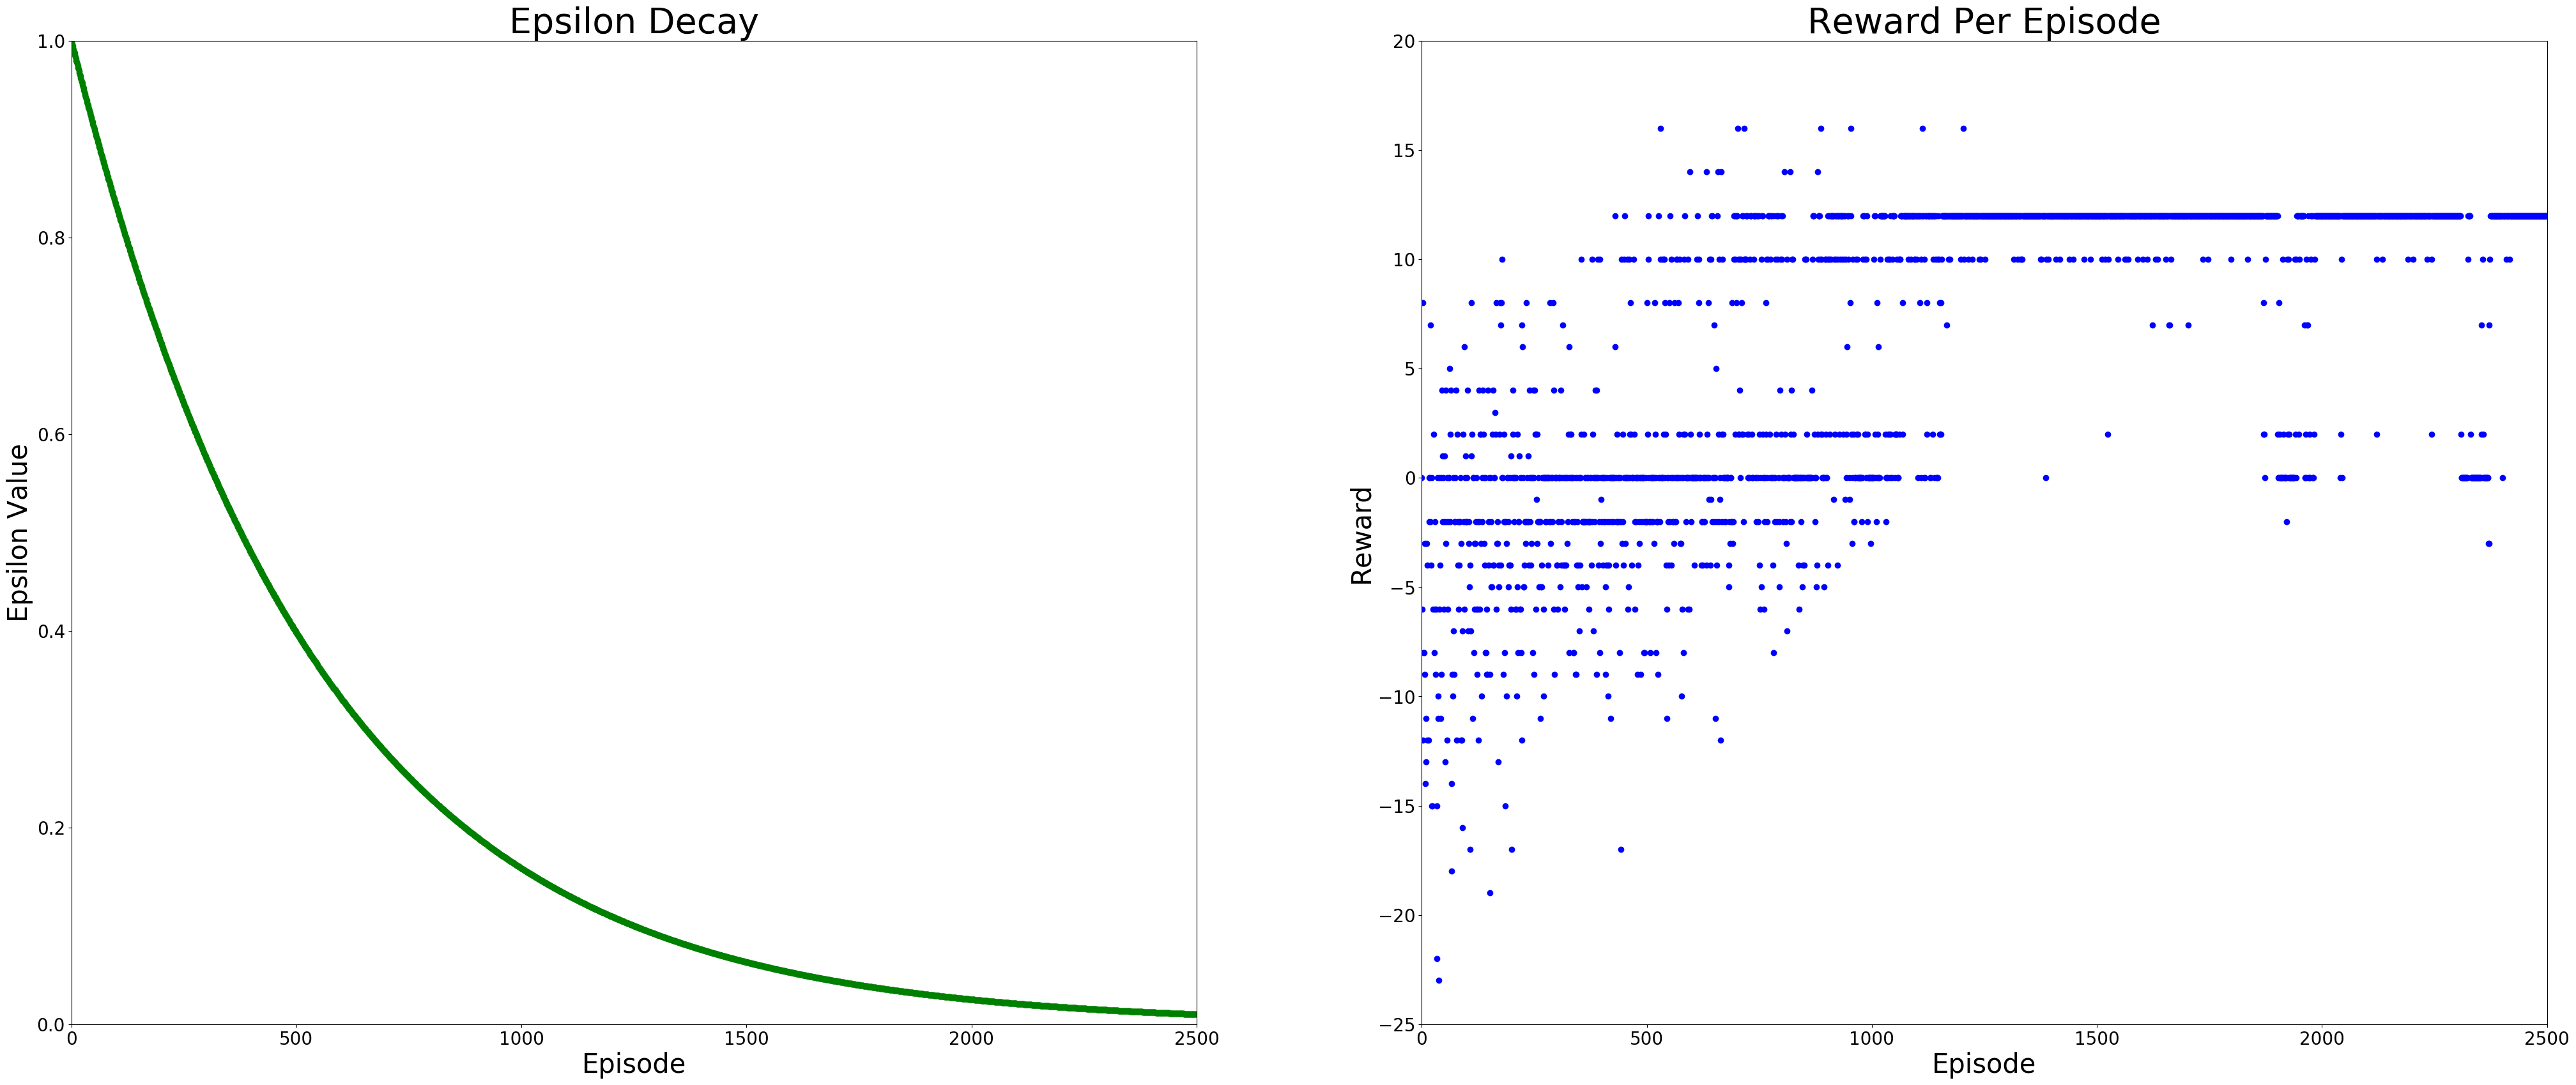

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(20)
fig.set_figwidth(50)
# fig.suptitle('Gamma Tuning', size="50")
ax1.plot(epsilon_list_train_dqn, 'go')
ax1.set_title("Epsilon Decay", size=40)
ax1.set_ylabel('Epsilon Value', fontsize = 30) 
ax1.set_xlabel('Episode', fontsize = 30)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(100)
ax1.set_xlim(xmin=0, xmax=a.max_episodes)
ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_train_dqn, 'bo')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=a.max_episodes)
ax2.set_ylim(ymin=-25, ymax=20)
plt.show()

In [19]:
rewardSD_train_dqn_avg = []
for s in np.split(np.array(reward_list_train_dqn), 25):
    rewardSD_train_dqn_avg.append((sum(s)/len(s)))
    
epsilonSD_train_dqn_avg = []
for s in np.split(np.array(epsilon_list_train_dqn), 25):
    epsilonSD_train_dqn_avg.append((sum(s)/len(s)))



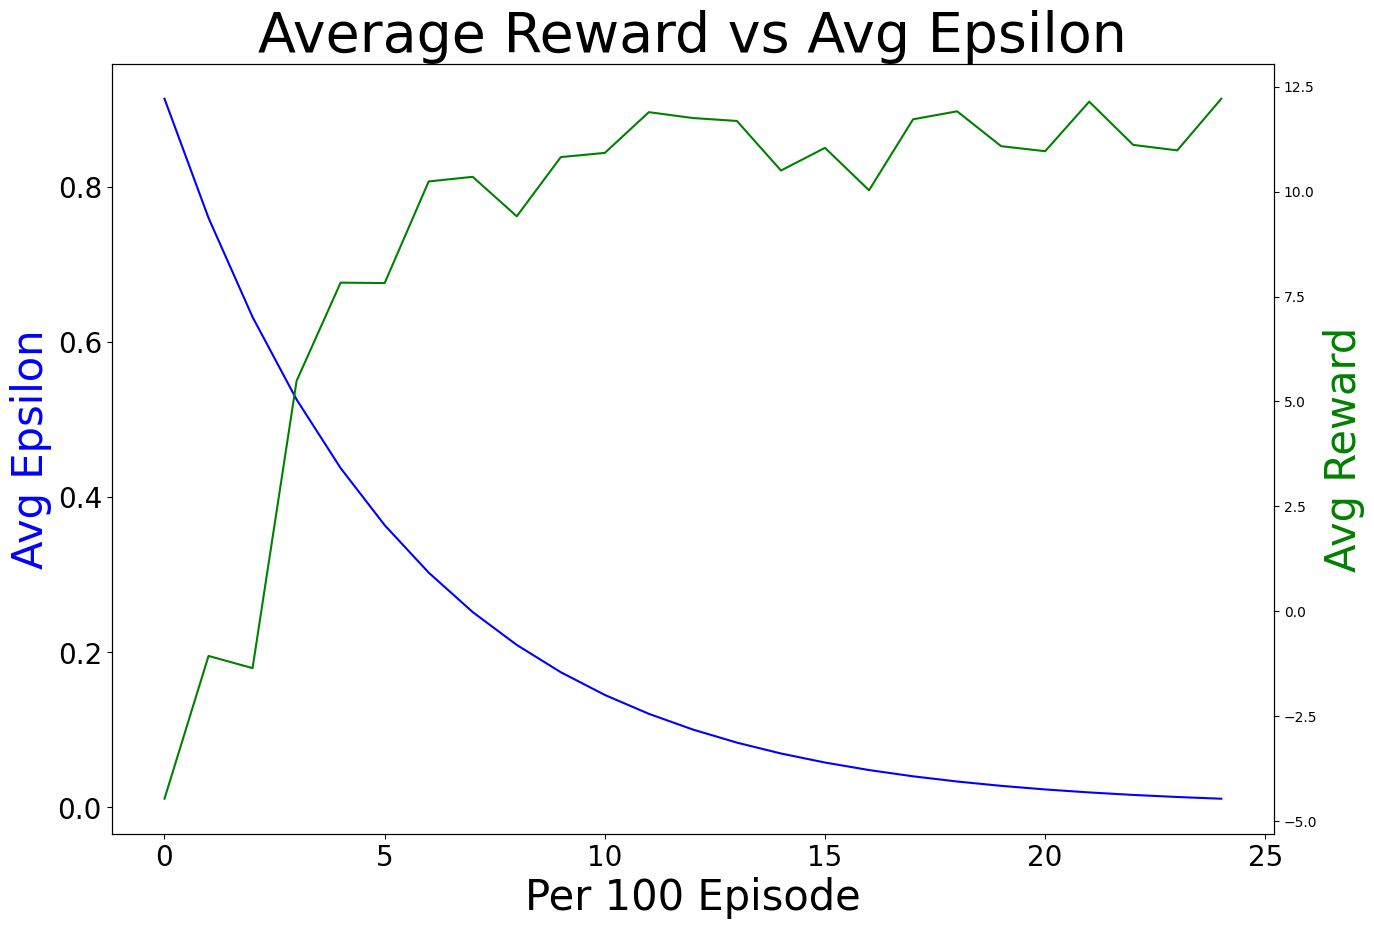

In [20]:
fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.tick_params(axis='both', which='major', labelsize=20)
ax2 = ax1.twinx()
ax1.plot(epsilonSD_train_dqn_avg, 'b-')
ax2.plot(rewardSD_train_dqn_avg, 'g-')
ax1.set_title("Average Reward vs Avg Epsilon", size=40)
ax1.set_xlabel('Per 100 Episode', fontsize=30)
ax1.set_ylabel('Avg Epsilon', color='b', fontsize=30)
ax2.set_ylabel('Avg Reward', color='g', fontsize=30)
plt.show()

In [21]:
PATH = './grid.pth'
torch.save(a.q_value_dqn.state_dict(), PATH)

## Evaluating the agent

In [22]:
env = MyMarioEnvironment(environment_type = 'deterministic')
env.reset()
a = GridVanillaDQN(env)
a.eval()

/tmp/ipykernel_8068/3657155398.py:17: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(84, interpolation=Image.CUBIC),
100%|██████████| 10/10 [00:00<00:00, 316.10episodes/s]


In [23]:
reward_list_test_dqn = a.test_rewards_list

In [25]:
print(reward_list_test_dqn)

[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]


## Plotting the results

<Figure size 640x480 with 0 Axes>

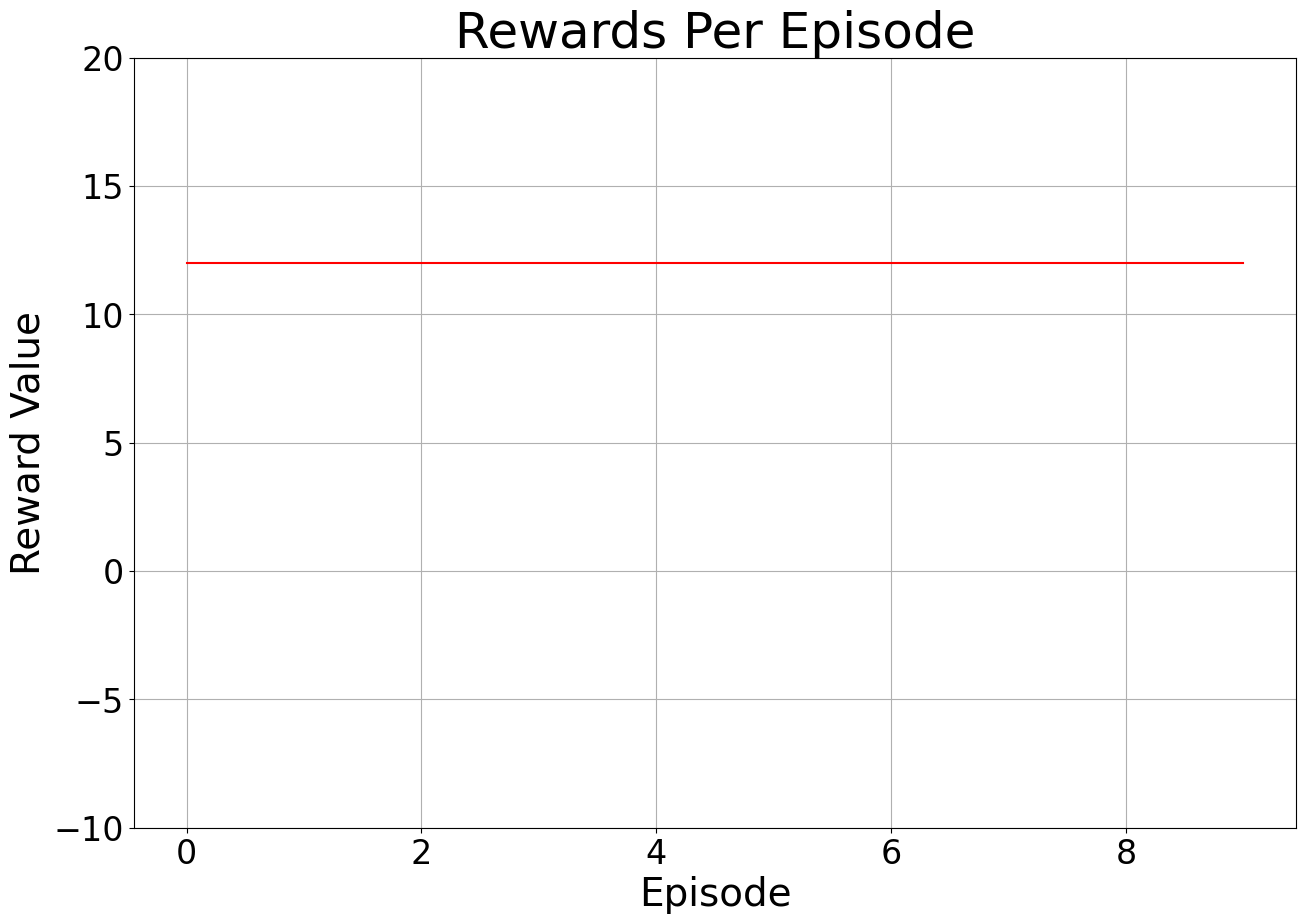

In [24]:
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(reward_list_test_dqn, 'r-')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title(f'Rewards Per Episode', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.yticks([-100, -50, 0, 10, 20], fontsize=24)
plt.ylim(ymin=-10, ymax=20)
# plt.xlim(xmin=0, xmax=self.max_episodes_test)
plt.grid()
plt.show()

DDQN

In [33]:
class GridDoubleDQN():
    def __init__(self, env, typ="dense"):
      self.env = env
      self.typ = typ
      self.max_episodes = 2500
      self.max_steps = 30
      self.gamma = 0.99
      self.epsilon = 1.0
      self.epsilon_min = 0.01
      self.epsilon_decay_lamda = self.epsilon_min**(1/self.max_episodes)
      self.target_update_counter = 0
      self.target_update_frequency = 10
      self.buffer_minibatch_size = 32
      self.replay_buffer_capacity=2000
      self.replay_buffer = deque([],maxlen=self.replay_buffer_capacity)
      self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(84, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])  
      env.reset()
#       _, _, self.state_screen_h, self.state_screen_w = self.screen_preprocessor(self.env.render()).shape
      lenn = len(self.env.reset()[1])
      self.state_count = env.observation_space.n
      self.action_count = env.action_space.n
      self.target_dqn = DQN_FC(lenn, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      self.q_value_dqn = DQN_FC(lenn, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      # self.rms_optimizer = optim.RMSprop(self.q_value_dqn.parameters())#, lr=0.001)#, weight_decay=0.05)
      # self.loss_func = F.smooth_l1_loss
      self.rms_optimizer = optim.SGD(self.q_value_dqn.parameters(), lr=0.005)#optim.RMSprop(self.q_value_dqn.parameters(), lr=0.001)#, weight_decay=0.05)
      self.loss_func = F.mse_loss #F.smooth_l1_loss
      
      self.timestep_list = []
      self.rewards_list = []
      self.epsilon_list = []
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.q_value_dqn#.to(self.device)
      self.target_dqn#.to(self.device)

      self.test_max_episodes = 10
      self.test_timestep_list = []
      self.test_rewards_list = []
      self.test_epsilon_list = []
      self.trained_policy_path = "./grid.pth"

    def initialize_buffer(self):
      for i in range(self.replay_buffer_capacity):
#         current_state = np.where(self.env.reset() == 1)
#         current_state = 
        done = False
        while not done:  
            current_action = self.choose_action(torch.as_tensor(current_state, dtype=torch.float))#.to(self.device)
            next_state, curr_reward, done, truncated, info = self.env.step(current_action)
#           next_state = self.screen_preprocessor(self.env.render())

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            current_state = next_state

    def screen_preprocessor(self,state_screen):
      def crop(variable,tw,th):
         c, h, w = variable.shape
         x1 = int(round((w - tw) / 2.))
         y1 = int(round((h - th) / 2.))
         return variable[:,y1:y1+th,x1:x1+tw]
      state_screen = state_screen.transpose((2,0,1))
      screen_c, screen_h, screen_w = state_screen.shape
      screen = self.resize(torch.from_numpy(state_screen))
      screen = crop(screen, 60, 60)
      screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
      screen = torch.from_numpy(screen)
      return screen.unsqueeze(0)
    
    def choose_action(self, state, test=False):
      random_no = np.random.random()
      if self.epsilon > random_no and not test:
          return np.random.choice(self.env.action_space.n)
      else:
          return torch.argmax(self.q_value_dqn(state)).item()#.to(self.device))
    
    def get_q_value_for_state(self, state):
      q_values = self.q_value_dqn(state)
      return q_values.max(1)[1].view(1, 1)

    def eval(self,load=False):
      if load:
        self.q_value_dqn.load_state_dict(torch.load(self.trained_policy_path))

      for episode in tqdm(range(0, self.test_max_episodes), unit='episodes'):
        aud, obs = self.env.reset()
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
          tt = time.time()

          current_action = self.choose_action(current_state, test=True)#.to(self.device)
          curr_aud, curr_obs, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
          curr_obs = torch.tensor(curr_obs,dtype=torch.float)
          
          reward_sum += curr_reward
          next_state = curr_obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

          steps +=1
          
          current_state = next_state
          if steps==20 or reward_sum==16:
            done=True
            
        self.test_timestep_list.append(steps)
        self.test_rewards_list.append(reward_sum)


    def train(self):
      current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch = self.get_minibatch_from_replay_buffer()
#       print(current_state_batch)
      curr_q_value_list = self.q_value_dqn(current_state_batch).gather(1, current_action_batch.reshape([self.buffer_minibatch_size,1])) #.to(self.device)).gather(1, current_action_batch)
#       next_q_value_list = self.target_dqn(next_state_batch)#.to(self.device))

      next_q_value_list = self.target_dqn(next_state_batch)
    
      with torch.no_grad():
          best_actions = torch.argmax(self.q_value_dqn(next_state_batch), dim=1)

      next_q_value_list = next_q_value_list.gather(1, best_actions.reshape([self.buffer_minibatch_size, 1]))
      next_q_value_list = next_q_value_list.detach()
      exp_q_value_list = []
      for index in range(self.buffer_minibatch_size):
        # if current_done_batch[index]:
        #   exp_q_value_list.append(current_reward_batch[index])
        # else:
          exp_q_value_list.append((current_reward_batch[index] + next_q_value_list[index] * self.gamma))

      exp_q_value_list = torch.tensor(exp_q_value_list).unsqueeze(1)#.to(self.device)

      self.rms_optimizer.zero_grad()
      loss = self.loss_func(curr_q_value_list, exp_q_value_list)
      loss.backward()
      for param in self.q_value_dqn.parameters():
          param.grad.data.clamp_(-1, 1)
      self.rms_optimizer.step()

      return 0#loss.item()
      
    def learn(self):
      self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
      self.target_dqn.eval()
      
      running_loss=0
      loss=0
      self.tm = []
      self.tr = []
      for episode in tqdm(range(0, self.max_episodes), unit='episodes'):
        # with Profiler() as p:
        aud_obs, obs = self.env.reset()
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
            tt = time.time()

            current_action = self.choose_action(current_state)#.to(self.device)
            curr_audio,curr_obs, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
            curr_obs = torch.tensor(curr_obs, dtype=torch.float)
#             print(current_state, current_action, curr_obs, curr_reward, done)

            reward_sum += curr_reward

            next_state = curr_obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            t = time.time() 

            if len(self.replay_buffer) >= self.buffer_minibatch_size:       
                loss = self.train()
            self.tm.append(time.time()-t)
            steps +=1
            running_loss = loss*self.buffer_minibatch_size
            current_state = next_state

            self.tr.append(time.time()-tt)
            if steps==self.max_steps or reward_sum==16:
                done=True

        self.update_target_net(episode)
            
        self.timestep_list.append(steps)
        self.rewards_list.append(reward_sum)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.epsilon_decay_lamda) #if episode>500 else self.epsilon
      
        if episode % 100 == 99:
          print(f"Buffer_size: {len(self.replay_buffer)}|Train_time:{sum(self.tm[-100:])/100}| Sub_t:{sum(self.tr[-100:])/100}")
          # print(f'[Episode: {episode+1}] - Steps: {steps+1} | Rewards: {reward_sum+1} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          print(f'[Episode: {episode+1}] - Steps: {sum(self.timestep_list[-100:])/100} | Rewards: {sum(self.rewards_list[-100:])/100} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          running_loss = 0.0
          # p.print()
        
    def update_target_net(self, episode):
       tao = 0.7
       if episode % self.target_update_frequency == self.target_update_frequency-1:   
#           self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
          q_value_dict = self.q_value_dqn.state_dict()
          target_dict = self.target_dqn.state_dict()
          for pred_param, target_param in zip(q_value_dict.items(), target_dict.items()):
              new_param = tao * pred_param[1] + (1-tao)*target_param[1]
              target_param[1].copy_(new_param)
              
    
    def get_minibatch_from_replay_buffer(self):
      exp_batch = random.sample(self.replay_buffer, self.buffer_minibatch_size) #max(len(self.replay_buffer), self.buffer_minibatch_size))
      current_state_batch = torch.cat(tuple([exp[0] for exp in exp_batch]),dim=0)
#       current_action_batch = torch.cat(tuple([exp[1] for exp in exp_batch]),dim=0)
      current_action_batch = torch.as_tensor([exp[1] for exp in exp_batch])
      next_state_batch = torch.cat(tuple([exp[3] for exp in exp_batch]),dim=0)
      current_reward_batch = torch.tensor(tuple([exp[2] for exp in exp_batch]))#.to(self.device)
      current_done_batch = torch.tensor(tuple([exp[4] for exp in exp_batch]))#.to(self.device)
      return current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch
    
    def add_to_replay_buffer(self, experience):
       self.replay_buffer.append(experience)

In [27]:
from mario2 import MyMarioEnvironment2

In [28]:
env = MyMarioEnvironment2(environment_type = 'deterministic')
obs = env.reset()
da = GridDoubleDQN(env)
da.learn()

  4%|▍         | 101/2500 [00:09<03:30, 11.42episodes/s]

Buffer_size: 2000|Train_time:0.002551722526550293| Sub_t:0.002936577796936035
[Episode: 100] - Steps: 29.66 | Rewards: -6.48 | Epsilon: 0.8317637711026726 | loss: 0.000


  8%|▊         | 201/2500 [00:18<03:26, 11.16episodes/s]

Buffer_size: 2000|Train_time:0.0025382280349731446| Sub_t:0.0029661941528320314
[Episode: 200] - Steps: 29.88 | Rewards: -4.13 | Epsilon: 0.691830970918939 | loss: 0.000


 12%|█▏        | 301/2500 [00:27<02:38, 13.83episodes/s]

Buffer_size: 2000|Train_time:0.00255631685256958| Sub_t:0.003043215274810791
[Episode: 300] - Steps: 27.48 | Rewards: 0.9 | Epsilon: 0.5754399373371608 | loss: 0.000


 16%|█▌        | 401/2500 [00:34<02:22, 14.76episodes/s]

Buffer_size: 2000|Train_time:0.0024676251411437987| Sub_t:0.0029523944854736328
[Episode: 400] - Steps: 24.6 | Rewards: 6.76 | Epsilon: 0.47863009232264275 | loss: 0.000


 20%|██        | 502/2500 [00:43<02:56, 11.29episodes/s]

Buffer_size: 2000|Train_time:0.0026897788047790527| Sub_t:0.003223717212677002
[Episode: 500] - Steps: 23.76 | Rewards: 5.07 | Epsilon: 0.3981071705535017 | loss: 0.000


 24%|██▍       | 602/2500 [00:50<02:11, 14.39episodes/s]

Buffer_size: 2000|Train_time:0.002488832473754883| Sub_t:0.002970738410949707
[Episode: 600] - Steps: 21.82 | Rewards: 7.21 | Epsilon: 0.3311311214825956 | loss: 0.000


 28%|██▊       | 703/2500 [00:57<01:38, 18.32episodes/s]

Buffer_size: 2000|Train_time:0.0025587725639343263| Sub_t:0.003133745193481445
[Episode: 700] - Steps: 18.99 | Rewards: 8.36 | Epsilon: 0.27542287033382085 | loss: 0.000


 32%|███▏      | 801/2500 [01:03<01:48, 15.62episodes/s]

Buffer_size: 2000|Train_time:0.0025129461288452147| Sub_t:0.0030690646171569825
[Episode: 800] - Steps: 18.92 | Rewards: 8.09 | Epsilon: 0.22908676527678132 | loss: 0.000


 36%|███▌      | 903/2500 [01:10<01:34, 16.92episodes/s]

Buffer_size: 2000|Train_time:0.0026317524909973146| Sub_t:0.003233470916748047
[Episode: 900] - Steps: 17.84 | Rewards: 8.11 | Epsilon: 0.19054607179632832 | loss: 0.000


 40%|████      | 1002/2500 [01:16<01:13, 20.26episodes/s]

Buffer_size: 2000|Train_time:0.002567899227142334| Sub_t:0.0031280755996704102
[Episode: 1000] - Steps: 17.63 | Rewards: 8.82 | Epsilon: 0.15848931924611465 | loss: 0.000


 44%|████▍     | 1102/2500 [01:22<01:51, 12.53episodes/s]

Buffer_size: 2000|Train_time:0.002476794719696045| Sub_t:0.0030591678619384765
[Episode: 1100] - Steps: 18.77 | Rewards: 3.14 | Epsilon: 0.13182567385564378 | loss: 0.000


 48%|████▊     | 1203/2500 [01:29<01:16, 16.94episodes/s]

Buffer_size: 2000|Train_time:0.0024598908424377443| Sub_t:0.003015909194946289
[Episode: 1200] - Steps: 20.65 | Rewards: 6.87 | Epsilon: 0.10964781961432139 | loss: 0.000


 52%|█████▏    | 1303/2500 [01:35<01:15, 15.92episodes/s]

Buffer_size: 2000|Train_time:0.00246826171875| Sub_t:0.003052196502685547
[Episode: 1300] - Steps: 20.64 | Rewards: 0.48 | Epsilon: 0.09120108393559365 | loss: 0.000


 56%|█████▌    | 1401/2500 [01:44<01:45, 10.38episodes/s]

Buffer_size: 2000|Train_time:0.002835183143615723| Sub_t:0.0034342551231384276
[Episode: 1400] - Steps: 23.62 | Rewards: 6.46 | Epsilon: 0.07585775750292077 | loss: 0.000


 60%|██████    | 1502/2500 [01:51<01:03, 15.67episodes/s]

Buffer_size: 2000|Train_time:0.0029994916915893556| Sub_t:0.0036809229850769043
[Episode: 1500] - Steps: 20.33 | Rewards: 2.62 | Epsilon: 0.06309573444802141 | loss: 0.000


 64%|██████▍   | 1603/2500 [01:58<00:56, 16.00episodes/s]

Buffer_size: 2000|Train_time:0.0027372074127197266| Sub_t:0.0034411644935607912
[Episode: 1600] - Steps: 17.75 | Rewards: 8.63 | Epsilon: 0.052480746024979104 | loss: 0.000


 68%|██████▊   | 1702/2500 [02:04<00:44, 18.07episodes/s]

Buffer_size: 2000|Train_time:0.0024296188354492186| Sub_t:0.0030162739753723145
[Episode: 1700] - Steps: 16.95 | Rewards: 8.37 | Epsilon: 0.043651583224018214 | loss: 0.000


 72%|███████▏  | 1804/2500 [02:09<00:27, 25.06episodes/s]

Buffer_size: 2000|Train_time:0.0025281643867492674| Sub_t:0.003115408420562744
[Episode: 1800] - Steps: 15.46 | Rewards: 8.46 | Epsilon: 0.03630780547701154 | loss: 0.000


 76%|███████▌  | 1902/2500 [02:14<00:28, 21.01episodes/s]

Buffer_size: 2000|Train_time:0.0027590322494506834| Sub_t:0.003414623737335205
[Episode: 1900] - Steps: 14.65 | Rewards: 7.93 | Epsilon: 0.030199517204021385 | loss: 0.000


 80%|████████  | 2002/2500 [02:19<00:31, 15.71episodes/s]

Buffer_size: 2000|Train_time:0.003462183475494385| Sub_t:0.0041645455360412595
[Episode: 2000] - Steps: 13.86 | Rewards: 8.48 | Epsilon: 0.025118864315096866 | loss: 0.000


 84%|████████▍ | 2102/2500 [02:24<00:17, 23.38episodes/s]

Buffer_size: 2000|Train_time:0.0026429986953735354| Sub_t:0.0032425212860107424
[Episode: 2100] - Steps: 13.99 | Rewards: 8.01 | Epsilon: 0.02089296130854132 | loss: 0.000


 88%|████████▊ | 2202/2500 [02:30<00:20, 14.39episodes/s]

Buffer_size: 2000|Train_time:0.002515585422515869| Sub_t:0.0030922627449035643
[Episode: 2200] - Steps: 17.1 | Rewards: 6.91 | Epsilon: 0.017378008287494567 | loss: 0.000


 92%|█████████▏| 2301/2500 [02:35<00:09, 20.18episodes/s]

Buffer_size: 2000|Train_time:0.0026252150535583498| Sub_t:0.003324167728424072
[Episode: 2300] - Steps: 13.89 | Rewards: 9.25 | Epsilon: 0.014454397707459973 | loss: 0.000


 96%|█████████▌| 2404/2500 [02:40<00:04, 23.98episodes/s]

Buffer_size: 2000|Train_time:0.0026386332511901854| Sub_t:0.0032474064826965333
[Episode: 2400] - Steps: 14.21 | Rewards: 8.42 | Epsilon: 0.012022644346174735 | loss: 0.000


100%|██████████| 2500/2500 [02:45<00:00, 15.12episodes/s]

Buffer_size: 2000|Train_time:0.0024007320404052734| Sub_t:0.0029849457740783692
[Episode: 2500] - Steps: 14.91 | Rewards: 6.14 | Epsilon: 0.01000000000000053 | loss: 0.000


In [29]:
epsilon_list_train_dqn = da.epsilon_list
reward_list_train_dqn = da.rewards_list

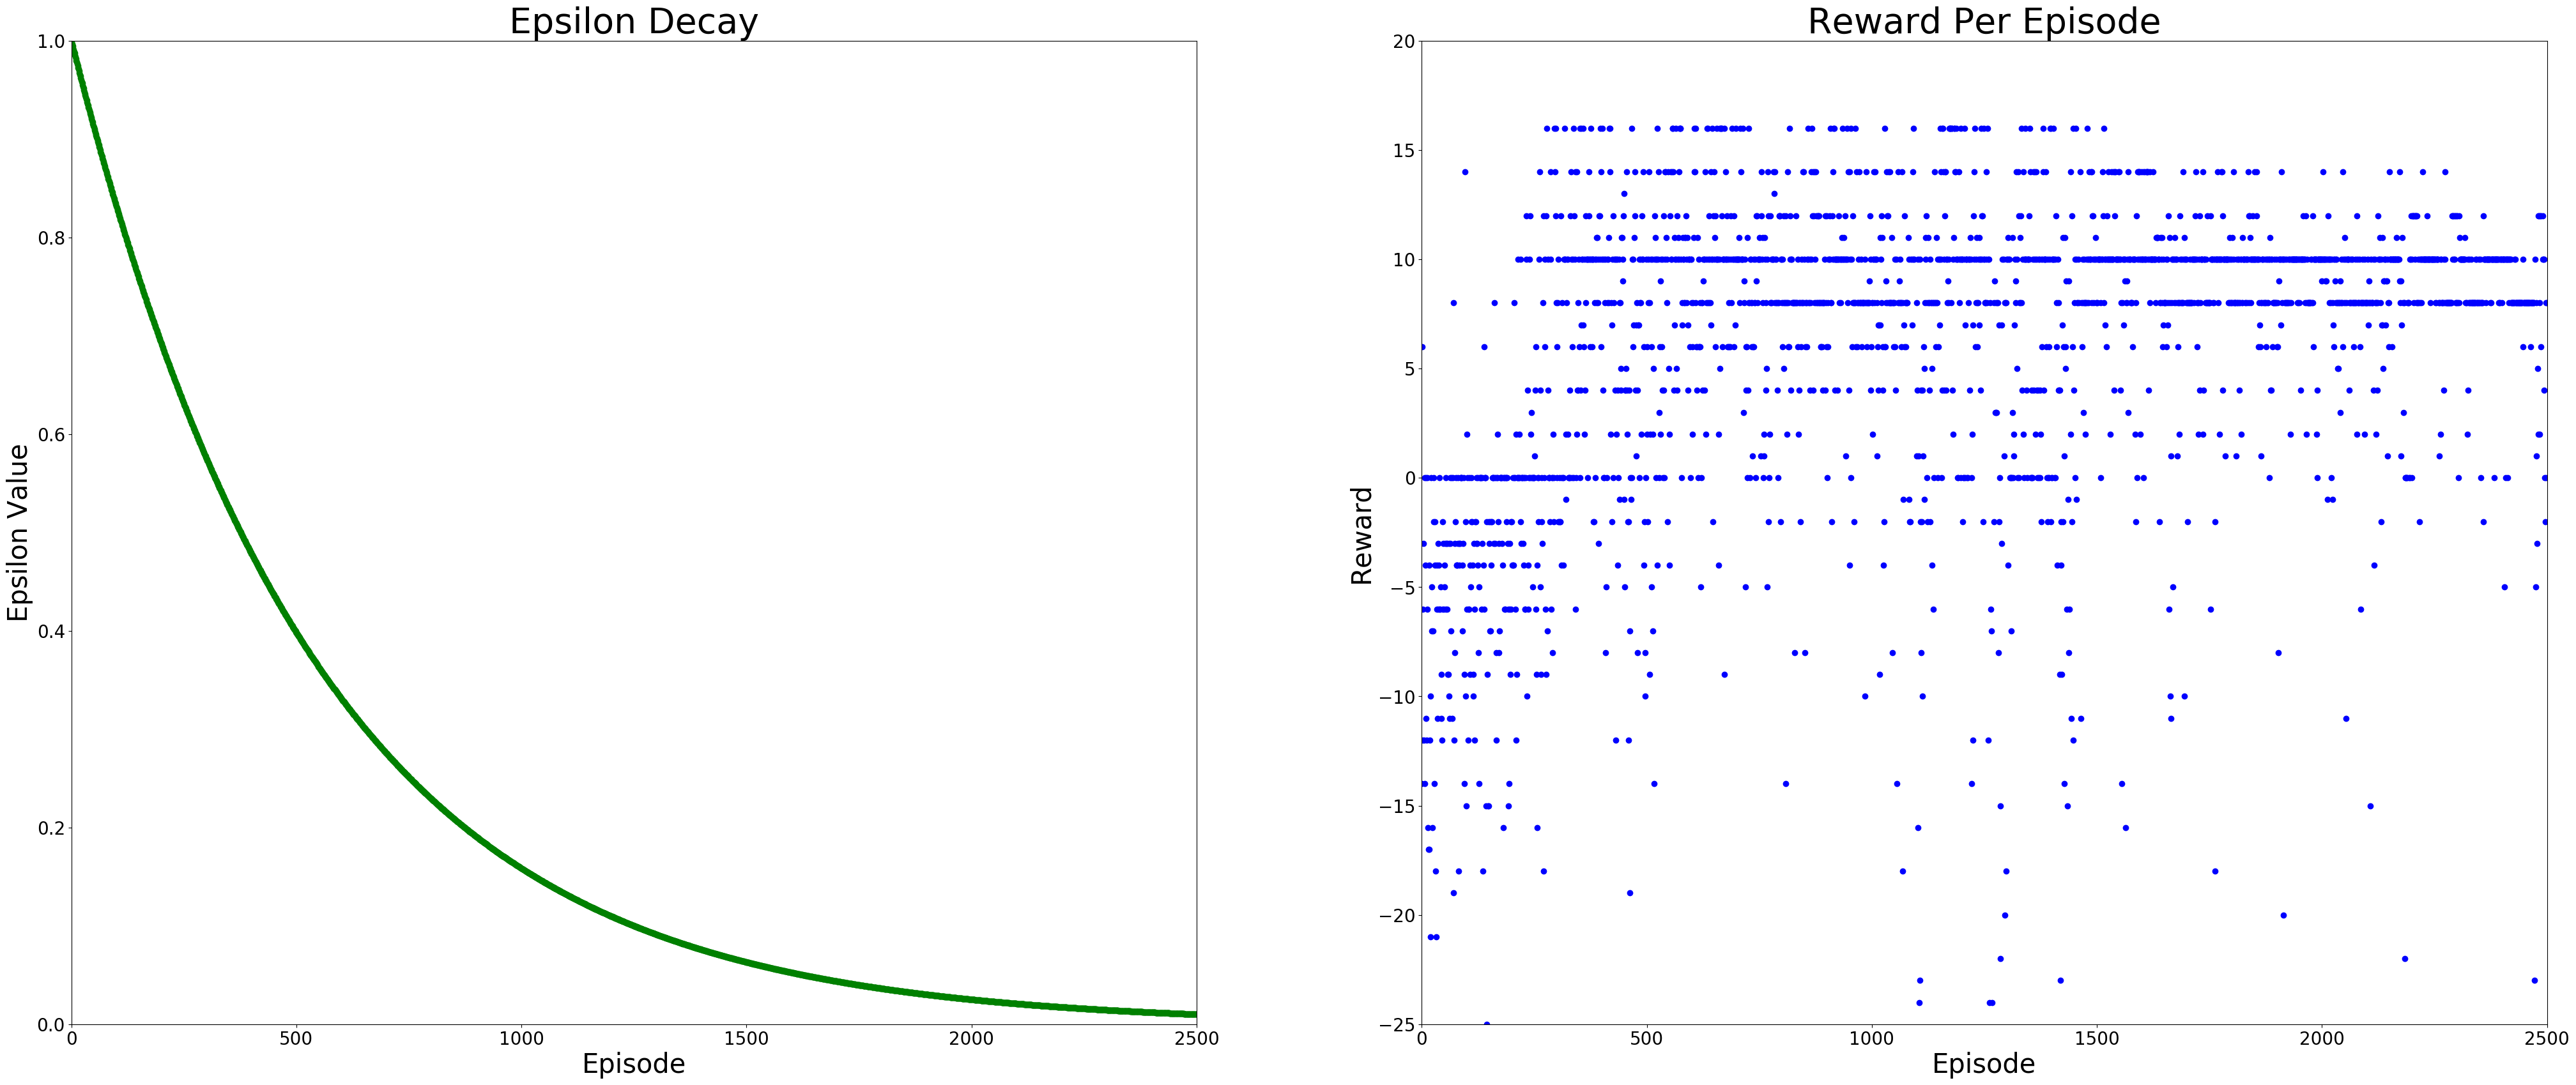

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(20)
fig.set_figwidth(50)
# fig.suptitle('Gamma Tuning', size="50")
ax1.plot(epsilon_list_train_dqn, 'go')
ax1.set_title("Epsilon Decay", size=40)
ax1.set_ylabel('Epsilon Value', fontsize = 30) 
ax1.set_xlabel('Episode', fontsize = 30)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(100)
ax1.set_xlim(xmin=0, xmax=da.max_episodes)
ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_train_dqn, 'bo')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=da.max_episodes)
ax2.set_ylim(ymin=-25, ymax=20)
plt.show()

In [31]:
PATH = './grid.pth'
torch.save(da.q_value_dqn.state_dict(), PATH)

In [34]:
env = MyMarioEnvironment2(environment_type = 'deterministic')
env.reset()
da = GridDoubleDQN(env)
da.eval(load=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
100%|██████████| 10/10 [00:00<00:00, 130.34episodes/s]


In [35]:
reward_list_test_dqn = da.test_rewards_list
print(reward_list_test_dqn)

[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]


<Figure size 640x480 with 0 Axes>

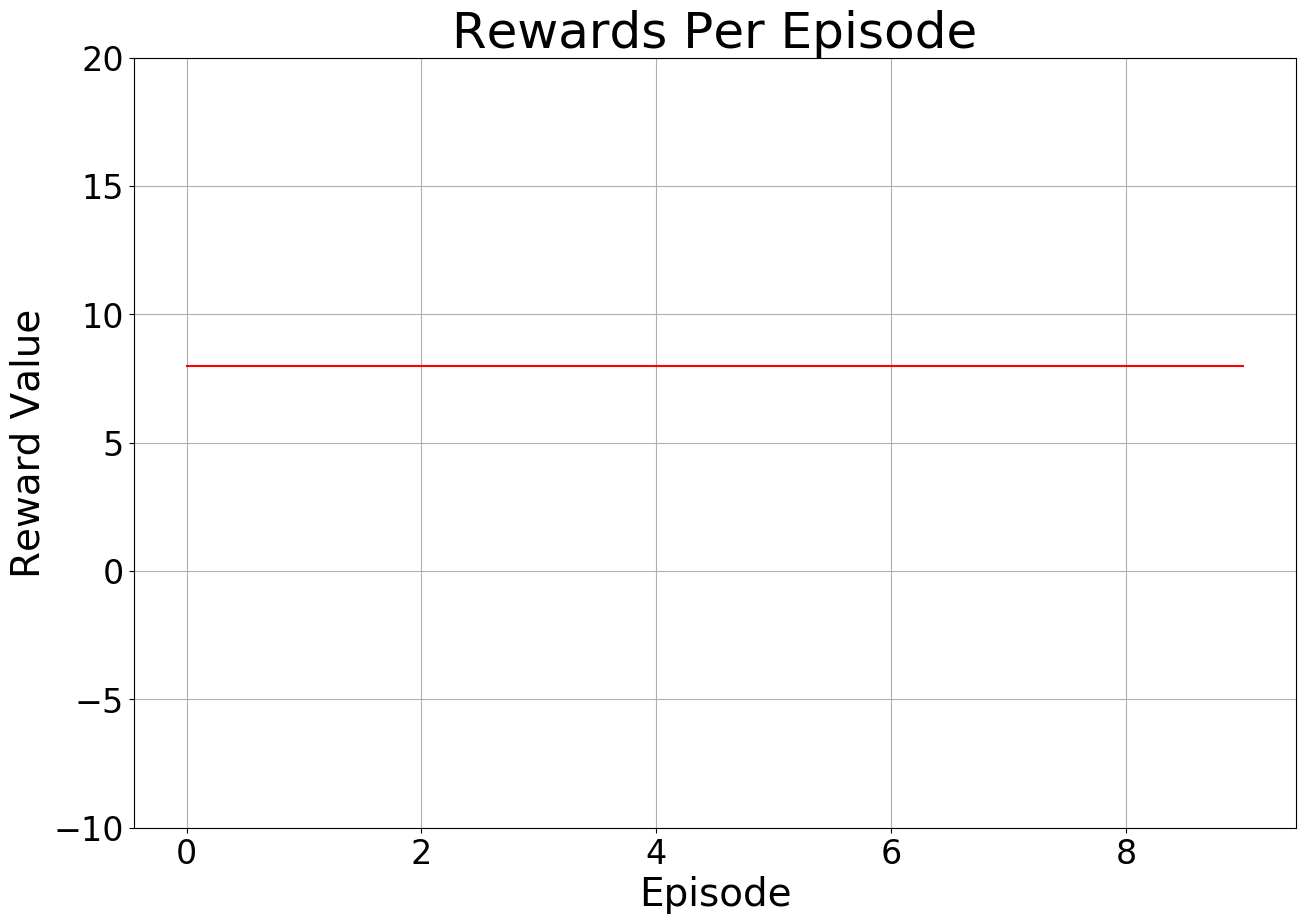

In [36]:
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(reward_list_test_dqn, 'r-')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title(f'Rewards Per Episode', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.yticks([-100, -50, 0, 10, 20], fontsize=24)
plt.ylim(ymin=-10, ymax=20)
# plt.xlim(xmin=0, xmax=self.max_episodes_test)
plt.grid()
plt.show()

In [37]:
class GridDoubleDQN():
    def __init__(self, env, typ="dense"):
      self.env = env
      self.typ = typ
      self.max_episodes = 2500
      self.max_steps = 30
      self.gamma = 0.99
      self.epsilon = 1.0
      self.epsilon_min = 0.01
      self.epsilon_decay_lamda = self.epsilon_min**(1/self.max_episodes)
      self.target_update_counter = 0
      self.target_update_frequency = 10
      self.buffer_minibatch_size = 32
      self.replay_buffer_capacity=2000
      self.replay_buffer = deque([],maxlen=self.replay_buffer_capacity)
      self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(84, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])  
      env.reset()
#       _, _, self.state_screen_h, self.state_screen_w = self.screen_preprocessor(self.env.render()).shape
      lenn = len(self.env.reset()[0])
      self.state_count = env.observation_space.n
      self.action_count = env.action_space.n
      self.target_dqn = DQN_FC(lenn, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      self.q_value_dqn = DQN_FC(lenn, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      # self.rms_optimizer = optim.RMSprop(self.q_value_dqn.parameters())#, lr=0.001)#, weight_decay=0.05)
      # self.loss_func = F.smooth_l1_loss
      self.rms_optimizer = optim.SGD(self.q_value_dqn.parameters(), lr=0.005)#optim.RMSprop(self.q_value_dqn.parameters(), lr=0.001)#, weight_decay=0.05)
      self.loss_func = F.mse_loss #F.smooth_l1_loss
      
      self.timestep_list = []
      self.rewards_list = []
      self.epsilon_list = []
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.q_value_dqn#.to(self.device)
      self.target_dqn#.to(self.device)

      self.test_max_episodes = 10
      self.test_timestep_list = []
      self.test_rewards_list = []
      self.test_epsilon_list = []
      self.trained_policy_path = "./grid.pth"

    def initialize_buffer(self):
      for i in range(self.replay_buffer_capacity):
#         current_state = np.where(self.env.reset() == 1)
#         current_state = 
        done = False
        while not done:  
            current_action = self.choose_action(torch.as_tensor(current_state, dtype=torch.float))#.to(self.device)
            next_state, curr_reward, done, truncated, info = self.env.step(current_action)
#           next_state = self.screen_preprocessor(self.env.render())

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            current_state = next_state

    def screen_preprocessor(self,state_screen):
      def crop(variable,tw,th):
         c, h, w = variable.shape
         x1 = int(round((w - tw) / 2.))
         y1 = int(round((h - th) / 2.))
         return variable[:,y1:y1+th,x1:x1+tw]
      state_screen = state_screen.transpose((2,0,1))
      screen_c, screen_h, screen_w = state_screen.shape
      screen = self.resize(torch.from_numpy(state_screen))
      screen = crop(screen, 60, 60)
      screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
      screen = torch.from_numpy(screen)
      return screen.unsqueeze(0)
    
    def choose_action(self, state, test=False):
      random_no = np.random.random()
      if self.epsilon > random_no and not test:
          return np.random.choice(self.env.action_space.n)
      else:
          return torch.argmax(self.q_value_dqn(state)).item()#.to(self.device))
    
    def get_q_value_for_state(self, state):
      q_values = self.q_value_dqn(state)
      return q_values.max(1)[1].view(1, 1)

    def eval(self,load=False):
      if load:
        self.q_value_dqn.load_state_dict(torch.load(self.trained_policy_path))

      for episode in tqdm(range(0, self.test_max_episodes), unit='episodes'):
        obs, aud = self.env.reset()
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
          tt = time.time()

          current_action = self.choose_action(current_state, test=True)#.to(self.device)
          curr_obs, curr_aud, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
          curr_obs = torch.tensor(curr_obs,dtype=torch.float)
          
          reward_sum += curr_reward
          next_state = curr_obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

          steps +=1
          
          current_state = next_state
          if steps==20 or reward_sum==16:
            done=True
            
        self.test_timestep_list.append(steps)
        self.test_rewards_list.append(reward_sum)


    def train(self):
      current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch = self.get_minibatch_from_replay_buffer()
#       print(current_state_batch)
      curr_q_value_list = self.q_value_dqn(current_state_batch).gather(1, current_action_batch.reshape([self.buffer_minibatch_size,1])) #.to(self.device)).gather(1, current_action_batch)
#       next_q_value_list = self.target_dqn(next_state_batch)#.to(self.device))

      next_q_value_list = self.target_dqn(next_state_batch)
    
      with torch.no_grad():
          best_actions = torch.argmax(self.q_value_dqn(next_state_batch), dim=1)

      next_q_value_list = next_q_value_list.gather(1, best_actions.reshape([self.buffer_minibatch_size, 1]))
      next_q_value_list = next_q_value_list.detach()
      exp_q_value_list = []
      for index in range(self.buffer_minibatch_size):
        # if current_done_batch[index]:
        #   exp_q_value_list.append(current_reward_batch[index])
        # else:
          exp_q_value_list.append((current_reward_batch[index] + next_q_value_list[index] * self.gamma))

      exp_q_value_list = torch.tensor(exp_q_value_list).unsqueeze(1)#.to(self.device)

      self.rms_optimizer.zero_grad()
      loss = self.loss_func(curr_q_value_list, exp_q_value_list)
      loss.backward()
      for param in self.q_value_dqn.parameters():
          param.grad.data.clamp_(-1, 1)
      self.rms_optimizer.step()

      return 0#loss.item()
      
    def learn(self):
      self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
      self.target_dqn.eval()
      
      running_loss=0
      loss=0
      self.tm = []
      self.tr = []
      for episode in tqdm(range(0, self.max_episodes), unit='episodes'):
        # with Profiler() as p:
        obs, aud_obs = self.env.reset()
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
            tt = time.time()

            current_action = self.choose_action(current_state)#.to(self.device)
            curr_obs, curr_audio, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
            curr_obs = torch.tensor(curr_obs, dtype=torch.float)
#             print(current_state, current_action, curr_obs, curr_reward, done)

            reward_sum += curr_reward

            next_state = curr_obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            t = time.time() 

            if len(self.replay_buffer) >= self.buffer_minibatch_size:       
                loss = self.train()
            self.tm.append(time.time()-t)
            steps +=1
            running_loss = loss*self.buffer_minibatch_size
            current_state = next_state

            self.tr.append(time.time()-tt)
            if steps==self.max_steps or reward_sum==16:
                done=True

        self.update_target_net(episode)
            
        self.timestep_list.append(steps)
        self.rewards_list.append(reward_sum)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.epsilon_decay_lamda) #if episode>500 else self.epsilon
      
        if episode % 100 == 99:
          print(f"Buffer_size: {len(self.replay_buffer)}|Train_time:{sum(self.tm[-100:])/100}| Sub_t:{sum(self.tr[-100:])/100}")
          # print(f'[Episode: {episode+1}] - Steps: {steps+1} | Rewards: {reward_sum+1} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          print(f'[Episode: {episode+1}] - Steps: {sum(self.timestep_list[-100:])/100} | Rewards: {sum(self.rewards_list[-100:])/100} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          running_loss = 0.0
          # p.print()
        
    def update_target_net(self, episode):
       tao = 0.7
       if episode % self.target_update_frequency == self.target_update_frequency-1:   
#           self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
          q_value_dict = self.q_value_dqn.state_dict()
          target_dict = self.target_dqn.state_dict()
          for pred_param, target_param in zip(q_value_dict.items(), target_dict.items()):
              new_param = tao * pred_param[1] + (1-tao)*target_param[1]
              target_param[1].copy_(new_param)
              
    
    def get_minibatch_from_replay_buffer(self):
      exp_batch = random.sample(self.replay_buffer, self.buffer_minibatch_size) #max(len(self.replay_buffer), self.buffer_minibatch_size))
      current_state_batch = torch.cat(tuple([exp[0] for exp in exp_batch]),dim=0)
#       current_action_batch = torch.cat(tuple([exp[1] for exp in exp_batch]),dim=0)
      current_action_batch = torch.as_tensor([exp[1] for exp in exp_batch])
      next_state_batch = torch.cat(tuple([exp[3] for exp in exp_batch]),dim=0)
      current_reward_batch = torch.tensor(tuple([exp[2] for exp in exp_batch]))#.to(self.device)
      current_done_batch = torch.tensor(tuple([exp[4] for exp in exp_batch]))#.to(self.device)
      return current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch
    
    def add_to_replay_buffer(self, experience):
       self.replay_buffer.append(experience)

In [38]:
env = MyMarioEnvironment2(environment_type = 'deterministic')
obs = env.reset()
da = GridDoubleDQN(env)
da.learn()

  4%|▍         | 101/2500 [00:12<03:23, 11.78episodes/s]

Buffer_size: 2000|Train_time:0.0025224018096923827| Sub_t:0.0029660630226135253
[Episode: 100] - Steps: 29.19 | Rewards: -6.78 | Epsilon: 0.8317637711026726 | loss: 0.000


  8%|▊         | 202/2500 [00:22<03:35, 10.68episodes/s]

Buffer_size: 2000|Train_time:0.0025021672248840333| Sub_t:0.002935206890106201
[Episode: 200] - Steps: 28.35 | Rewards: -3.38 | Epsilon: 0.691830970918939 | loss: 0.000


 12%|█▏        | 301/2500 [00:31<02:56, 12.49episodes/s]

Buffer_size: 2000|Train_time:0.0026050424575805664| Sub_t:0.0031786537170410156
[Episode: 300] - Steps: 27.43 | Rewards: 0.89 | Epsilon: 0.5754399373371608 | loss: 0.000


 16%|█▌        | 402/2500 [00:38<01:56, 17.96episodes/s]

Buffer_size: 2000|Train_time:0.002611503601074219| Sub_t:0.0031322073936462403
[Episode: 400] - Steps: 19.84 | Rewards: 10.83 | Epsilon: 0.47863009232264275 | loss: 0.000


 20%|██        | 500/2500 [00:43<01:44, 19.13episodes/s]

Buffer_size: 2000|Train_time:0.0025251007080078127| Sub_t:0.003073997497558594
[Episode: 500] - Steps: 17.07 | Rewards: 13.15 | Epsilon: 0.3981071705535017 | loss: 0.000


 24%|██▍       | 604/2500 [00:49<01:27, 21.75episodes/s]

Buffer_size: 2000|Train_time:0.0025954604148864745| Sub_t:0.003132479190826416
[Episode: 600] - Steps: 15.23 | Rewards: 13.49 | Epsilon: 0.3311311214825956 | loss: 0.000


 28%|██▊       | 704/2500 [00:54<01:26, 20.72episodes/s]

Buffer_size: 2000|Train_time:0.0026462364196777346| Sub_t:0.0032271909713745116
[Episode: 700] - Steps: 14.64 | Rewards: 14.73 | Epsilon: 0.27542287033382085 | loss: 0.000


 32%|███▏      | 804/2500 [00:58<01:13, 23.13episodes/s]

Buffer_size: 2000|Train_time:0.0024913620948791505| Sub_t:0.003070778846740723
[Episode: 800] - Steps: 13.71 | Rewards: 15.17 | Epsilon: 0.22908676527678132 | loss: 0.000


 36%|███▌      | 904/2500 [01:03<01:09, 23.02episodes/s]

Buffer_size: 2000|Train_time:0.0026548099517822265| Sub_t:0.003289041519165039
[Episode: 900] - Steps: 12.65 | Rewards: 15.44 | Epsilon: 0.19054607179632832 | loss: 0.000


 40%|████      | 1002/2500 [01:07<01:08, 21.94episodes/s]

Buffer_size: 2000|Train_time:0.002589828968048096| Sub_t:0.0031566500663757326
[Episode: 1000] - Steps: 12.63 | Rewards: 15.41 | Epsilon: 0.15848931924611465 | loss: 0.000


 44%|████▍     | 1102/2500 [01:12<01:02, 22.46episodes/s]

Buffer_size: 2000|Train_time:0.0027159547805786135| Sub_t:0.003310544490814209
[Episode: 1100] - Steps: 15.32 | Rewards: 14.79 | Epsilon: 0.13182567385564378 | loss: 0.000


 48%|████▊     | 1204/2500 [01:18<00:54, 23.64episodes/s]

Buffer_size: 2000|Train_time:0.0025902223587036134| Sub_t:0.003175363540649414
[Episode: 1200] - Steps: 13.86 | Rewards: 15.16 | Epsilon: 0.10964781961432139 | loss: 0.000


 52%|█████▏    | 1303/2500 [01:22<00:45, 26.10episodes/s]

Buffer_size: 2000|Train_time:0.002572357654571533| Sub_t:0.0031962847709655763
[Episode: 1300] - Steps: 13.21 | Rewards: 15.34 | Epsilon: 0.09120108393559365 | loss: 0.000


 56%|█████▌    | 1404/2500 [01:27<00:53, 20.42episodes/s]

Buffer_size: 2000|Train_time:0.0035472536087036133| Sub_t:0.004323761463165283
[Episode: 1400] - Steps: 13.83 | Rewards: 15.28 | Epsilon: 0.07585775750292077 | loss: 0.000


 60%|██████    | 1506/2500 [01:31<00:38, 25.96episodes/s]

Buffer_size: 2000|Train_time:0.002492856979370117| Sub_t:0.0030665159225463866
[Episode: 1500] - Steps: 11.48 | Rewards: 15.92 | Epsilon: 0.06309573444802141 | loss: 0.000


 64%|██████▍   | 1604/2500 [01:35<00:39, 22.52episodes/s]

Buffer_size: 2000|Train_time:0.002484862804412842| Sub_t:0.00305938720703125
[Episode: 1600] - Steps: 12.66 | Rewards: 15.64 | Epsilon: 0.052480746024979104 | loss: 0.000


 68%|██████▊   | 1702/2500 [01:39<00:41, 19.36episodes/s]

Buffer_size: 2000|Train_time:0.0024640035629272462| Sub_t:0.0030883216857910158
[Episode: 1700] - Steps: 13.17 | Rewards: 15.14 | Epsilon: 0.043651583224018214 | loss: 0.000


 72%|███████▏  | 1801/2500 [01:43<00:27, 25.34episodes/s]

Buffer_size: 2000|Train_time:0.002546675205230713| Sub_t:0.0031401872634887694
[Episode: 1800] - Steps: 11.55 | Rewards: 15.58 | Epsilon: 0.03630780547701154 | loss: 0.000


 76%|███████▌  | 1903/2500 [01:48<00:27, 21.77episodes/s]

Buffer_size: 2000|Train_time:0.002458794116973877| Sub_t:0.0030810356140136717
[Episode: 1900] - Steps: 13.48 | Rewards: 14.78 | Epsilon: 0.030199517204021385 | loss: 0.000


 80%|████████  | 2002/2500 [01:51<00:19, 25.78episodes/s]

Buffer_size: 2000|Train_time:0.0025362491607666014| Sub_t:0.003162872791290283
[Episode: 2000] - Steps: 12.1 | Rewards: 15.62 | Epsilon: 0.025118864315096866 | loss: 0.000


 84%|████████▍ | 2104/2500 [01:56<00:14, 27.87episodes/s]

Buffer_size: 2000|Train_time:0.0028212523460388185| Sub_t:0.003462531566619873
[Episode: 2100] - Steps: 13.17 | Rewards: 15.08 | Epsilon: 0.02089296130854132 | loss: 0.000


 88%|████████▊ | 2202/2500 [02:00<00:15, 19.64episodes/s]

Buffer_size: 2000|Train_time:0.0024459123611450194| Sub_t:0.0030335164070129394
[Episode: 2200] - Steps: 12.55 | Rewards: 15.39 | Epsilon: 0.017378008287494567 | loss: 0.000


 92%|█████████▏| 2303/2500 [02:04<00:06, 28.86episodes/s]

Buffer_size: 2000|Train_time:0.002477302551269531| Sub_t:0.003054049015045166
[Episode: 2300] - Steps: 12.63 | Rewards: 15.5 | Epsilon: 0.014454397707459973 | loss: 0.000


 96%|█████████▌| 2405/2500 [02:09<00:04, 19.29episodes/s]

Buffer_size: 2000|Train_time:0.002853703498840332| Sub_t:0.003468437194824219
[Episode: 2400] - Steps: 15.01 | Rewards: 13.51 | Epsilon: 0.012022644346174735 | loss: 0.000


100%|██████████| 2500/2500 [02:12<00:00, 18.84episodes/s]

Buffer_size: 2000|Train_time:0.0025136542320251466| Sub_t:0.0030687999725341796
[Episode: 2500] - Steps: 10.16 | Rewards: 16.0 | Epsilon: 0.01000000000000053 | loss: 0.000


In [41]:
class GridDoubleDQN():
    def __init__(self, env, typ="dense"):
      self.env = env
      self.typ = typ
      self.max_episodes = 2500
      self.max_steps = 30
      self.gamma = 0.99
      self.epsilon = 1.0
      self.epsilon_min = 0.01
      self.epsilon_decay_lamda = self.epsilon_min**(1/self.max_episodes)
      self.target_update_counter = 0
      self.target_update_frequency = 10
      self.buffer_minibatch_size = 32
      self.replay_buffer_capacity=2000
      self.replay_buffer = deque([],maxlen=self.replay_buffer_capacity)
      self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(84, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])  
      env.reset()
#       _, _, self.state_screen_h, self.state_screen_w = self.screen_preprocessor(self.env.render()).shape
      obs = self.env.reset()[0]
      obs.extend(self.env.reset()[1])
      lenn = len(obs)
      self.state_count = env.observation_space.n
      self.action_count = env.action_space.n
      self.target_dqn = DQN_FC(lenn, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      self.q_value_dqn = DQN_FC(lenn, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      # self.rms_optimizer = optim.RMSprop(self.q_value_dqn.parameters())#, lr=0.001)#, weight_decay=0.05)
      # self.loss_func = F.smooth_l1_loss
      self.rms_optimizer = optim.SGD(self.q_value_dqn.parameters(), lr=0.005)#optim.RMSprop(self.q_value_dqn.parameters(), lr=0.001)#, weight_decay=0.05)
      self.loss_func = F.mse_loss #F.smooth_l1_loss
      
      self.timestep_list = []
      self.rewards_list = []
      self.epsilon_list = []
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.q_value_dqn#.to(self.device)
      self.target_dqn#.to(self.device)

      self.test_max_episodes = 10
      self.test_timestep_list = []
      self.test_rewards_list = []
      self.test_epsilon_list = []
      self.trained_policy_path = "./grid.pth"

    def initialize_buffer(self):
      for i in range(self.replay_buffer_capacity):
#         current_state = np.where(self.env.reset() == 1)
#         current_state = 
        done = False
        while not done:  
            current_action = self.choose_action(torch.as_tensor(current_state, dtype=torch.float))#.to(self.device)
            next_state, curr_reward, done, truncated, info = self.env.step(current_action)
#           next_state = self.screen_preprocessor(self.env.render())

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            current_state = next_state

    def screen_preprocessor(self,state_screen):
      def crop(variable,tw,th):
         c, h, w = variable.shape
         x1 = int(round((w - tw) / 2.))
         y1 = int(round((h - th) / 2.))
         return variable[:,y1:y1+th,x1:x1+tw]
      state_screen = state_screen.transpose((2,0,1))
      screen_c, screen_h, screen_w = state_screen.shape
      screen = self.resize(torch.from_numpy(state_screen))
      screen = crop(screen, 60, 60)
      screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
      screen = torch.from_numpy(screen)
      return screen.unsqueeze(0)
    
    def choose_action(self, state, test=False):
      random_no = np.random.random()
      if self.epsilon > random_no and not test:
          return np.random.choice(self.env.action_space.n)
      else:
          return torch.argmax(self.q_value_dqn(state)).item()#.to(self.device))
    
    def get_q_value_for_state(self, state):
      q_values = self.q_value_dqn(state)
      return q_values.max(1)[1].view(1, 1)

    def eval(self,load=False):
      if load:
        self.q_value_dqn.load_state_dict(torch.load(self.trained_policy_path))

      for episode in tqdm(range(0, self.test_max_episodes), unit='episodes'):
        obs, aud = self.env.reset()
        obs.extend(aud)
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
          tt = time.time()

          current_action = self.choose_action(current_state, test=True)#.to(self.device)
          curr_obs, curr_aud, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
          curr_obs.extend(curr_aud)
          curr_obs = torch.tensor(curr_obs,dtype=torch.float)
          
          reward_sum += curr_reward
          next_state = curr_obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

          steps +=1
          
          current_state = next_state
          if steps==20 or reward_sum==16:
            done=True
            
        self.test_timestep_list.append(steps)
        self.test_rewards_list.append(reward_sum)


    def train(self):
      current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch = self.get_minibatch_from_replay_buffer()
#       print(current_state_batch)
      curr_q_value_list = self.q_value_dqn(current_state_batch).gather(1, current_action_batch.reshape([self.buffer_minibatch_size,1])) #.to(self.device)).gather(1, current_action_batch)
#       next_q_value_list = self.target_dqn(next_state_batch)#.to(self.device))

      next_q_value_list = self.target_dqn(next_state_batch)
    
      with torch.no_grad():
          best_actions = torch.argmax(self.q_value_dqn(next_state_batch), dim=1)

      next_q_value_list = next_q_value_list.gather(1, best_actions.reshape([self.buffer_minibatch_size, 1]))
      next_q_value_list = next_q_value_list.detach()
      exp_q_value_list = []
      for index in range(self.buffer_minibatch_size):
        # if current_done_batch[index]:
        #   exp_q_value_list.append(current_reward_batch[index])
        # else:
          exp_q_value_list.append((current_reward_batch[index] + next_q_value_list[index] * self.gamma))

      exp_q_value_list = torch.tensor(exp_q_value_list).unsqueeze(1)#.to(self.device)

      self.rms_optimizer.zero_grad()
      loss = self.loss_func(curr_q_value_list, exp_q_value_list)
      loss.backward()
      for param in self.q_value_dqn.parameters():
          param.grad.data.clamp_(-1, 1)
      self.rms_optimizer.step()

      return 0#loss.item()
      
    def learn(self):
      self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
      self.target_dqn.eval()
      
      running_loss=0
      loss=0
      self.tm = []
      self.tr = []
      for episode in tqdm(range(0, self.max_episodes), unit='episodes'):
        # with Profiler() as p:
        obs, aud_obs = self.env.reset()
        obs.extend(aud_obs)
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
            tt = time.time()

            current_action = self.choose_action(current_state)#.to(self.device)
            curr_obs, curr_audio, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
            curr_obs.extend(curr_audio)
            curr_obs = torch.tensor(curr_obs, dtype=torch.float)
#             print(current_state, current_action, curr_obs, curr_reward, done)

            reward_sum += curr_reward

            next_state = curr_obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            t = time.time() 

            if len(self.replay_buffer) >= self.buffer_minibatch_size:       
                loss = self.train()
            self.tm.append(time.time()-t)
            steps +=1
            running_loss = loss*self.buffer_minibatch_size
            current_state = next_state

            self.tr.append(time.time()-tt)
            if steps==self.max_steps or reward_sum==16:
                done=True

        self.update_target_net(episode)
            
        self.timestep_list.append(steps)
        self.rewards_list.append(reward_sum)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.epsilon_decay_lamda) #if episode>500 else self.epsilon
      
        if episode % 100 == 99:
          print(f"Buffer_size: {len(self.replay_buffer)}|Train_time:{sum(self.tm[-100:])/100}| Sub_t:{sum(self.tr[-100:])/100}")
          # print(f'[Episode: {episode+1}] - Steps: {steps+1} | Rewards: {reward_sum+1} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          print(f'[Episode: {episode+1}] - Steps: {sum(self.timestep_list[-100:])/100} | Rewards: {sum(self.rewards_list[-100:])/100} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          running_loss = 0.0
          # p.print()
        
    def update_target_net(self, episode):
       tao = 0.7
       if episode % self.target_update_frequency == self.target_update_frequency-1:   
#           self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
          q_value_dict = self.q_value_dqn.state_dict()
          target_dict = self.target_dqn.state_dict()
          for pred_param, target_param in zip(q_value_dict.items(), target_dict.items()):
              new_param = tao * pred_param[1] + (1-tao)*target_param[1]
              target_param[1].copy_(new_param)
              
    
    def get_minibatch_from_replay_buffer(self):
      exp_batch = random.sample(self.replay_buffer, self.buffer_minibatch_size) #max(len(self.replay_buffer), self.buffer_minibatch_size))
      current_state_batch = torch.cat(tuple([exp[0] for exp in exp_batch]),dim=0)
#       current_action_batch = torch.cat(tuple([exp[1] for exp in exp_batch]),dim=0)
      current_action_batch = torch.as_tensor([exp[1] for exp in exp_batch])
      next_state_batch = torch.cat(tuple([exp[3] for exp in exp_batch]),dim=0)
      current_reward_batch = torch.tensor(tuple([exp[2] for exp in exp_batch]))#.to(self.device)
      current_done_batch = torch.tensor(tuple([exp[4] for exp in exp_batch]))#.to(self.device)
      return current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch
    
    def add_to_replay_buffer(self, experience):
       self.replay_buffer.append(experience)

In [42]:
env = MyMarioEnvironment2(environment_type = 'deterministic')
obs = env.reset()
da = GridDoubleDQN(env)
da.learn()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
  4%|▍         | 101/2500 [00:09<04:12,  9.48episodes/s]

Buffer_size: 2000|Train_time:0.0036578917503356932| Sub_t:0.004502458572387695
[Episode: 100] - Steps: 29.25 | Rewards: -5.4 | Epsilon: 0.8317637711026726 | loss: 0.000


  8%|▊         | 201/2500 [00:18<03:23, 11.32episodes/s]

Buffer_size: 2000|Train_time:0.0025485420227050783| Sub_t:0.003029346466064453
[Episode: 200] - Steps: 28.79 | Rewards: -2.43 | Epsilon: 0.691830970918939 | loss: 0.000


 12%|█▏        | 302/2500 [00:26<02:58, 12.32episodes/s]

Buffer_size: 2000|Train_time:0.0025190043449401854| Sub_t:0.0029822373390197754
[Episode: 300] - Steps: 25.01 | Rewards: 4.65 | Epsilon: 0.5754399373371608 | loss: 0.000


 16%|█▌        | 401/2500 [00:34<02:43, 12.82episodes/s]

Buffer_size: 2000|Train_time:0.0026255369186401365| Sub_t:0.0031351637840270996
[Episode: 400] - Steps: 23.74 | Rewards: 5.77 | Epsilon: 0.47863009232264275 | loss: 0.000


 20%|██        | 501/2500 [00:40<01:39, 20.16episodes/s]

Buffer_size: 2000|Train_time:0.002508273124694824| Sub_t:0.0030898642539978027
[Episode: 500] - Steps: 18.16 | Rewards: 11.39 | Epsilon: 0.3981071705535017 | loss: 0.000


 24%|██▍       | 603/2500 [00:44<01:30, 20.91episodes/s]

Buffer_size: 2000|Train_time:0.0026581430435180663| Sub_t:0.003159976005554199
[Episode: 600] - Steps: 14.97 | Rewards: 12.25 | Epsilon: 0.3311311214825956 | loss: 0.000


 28%|██▊       | 702/2500 [00:49<01:26, 20.68episodes/s]

Buffer_size: 2000|Train_time:0.002491741180419922| Sub_t:0.003078458309173584
[Episode: 700] - Steps: 13.82 | Rewards: 12.85 | Epsilon: 0.27542287033382085 | loss: 0.000


 32%|███▏      | 803/2500 [00:55<01:27, 19.40episodes/s]

Buffer_size: 2000|Train_time:0.002689907550811768| Sub_t:0.0032435941696166994
[Episode: 800] - Steps: 17.48 | Rewards: 10.68 | Epsilon: 0.22908676527678132 | loss: 0.000


 36%|███▌      | 903/2500 [01:02<01:28, 18.11episodes/s]

Buffer_size: 2000|Train_time:0.002559034824371338| Sub_t:0.0030923962593078615
[Episode: 900] - Steps: 22.89 | Rewards: 6.96 | Epsilon: 0.19054607179632832 | loss: 0.000


 40%|████      | 1003/2500 [01:09<01:58, 12.62episodes/s]

Buffer_size: 2000|Train_time:0.0025832128524780275| Sub_t:0.0031245279312133788
[Episode: 1000] - Steps: 21.0 | Rewards: 6.98 | Epsilon: 0.15848931924611465 | loss: 0.000


 44%|████▍     | 1102/2500 [01:19<02:22,  9.83episodes/s]

Buffer_size: 2000|Train_time:0.0026791858673095702| Sub_t:0.0033045530319213865
[Episode: 1100] - Steps: 26.46 | Rewards: 2.23 | Epsilon: 0.13182567385564378 | loss: 0.000


 48%|████▊     | 1201/2500 [01:29<02:02, 10.63episodes/s]

Buffer_size: 2000|Train_time:0.0025168704986572267| Sub_t:0.0030959272384643555
[Episode: 1200] - Steps: 29.44 | Rewards: 0.04 | Epsilon: 0.10964781961432139 | loss: 0.000


 52%|█████▏    | 1301/2500 [01:38<01:52, 10.65episodes/s]

Buffer_size: 2000|Train_time:0.002500917911529541| Sub_t:0.0031151700019836424
[Episode: 1300] - Steps: 29.79 | Rewards: 0.19 | Epsilon: 0.09120108393559365 | loss: 0.000


 56%|█████▌    | 1402/2500 [01:48<01:41, 10.83episodes/s]

Buffer_size: 2000|Train_time:0.002418367862701416| Sub_t:0.002958884239196777
[Episode: 1400] - Steps: 29.56 | Rewards: 0.21 | Epsilon: 0.07585775750292077 | loss: 0.000


 60%|██████    | 1501/2500 [01:57<01:33, 10.70episodes/s]

Buffer_size: 2000|Train_time:0.002468256950378418| Sub_t:0.003051459789276123
[Episode: 1500] - Steps: 30.0 | Rewards: -0.83 | Epsilon: 0.06309573444802141 | loss: 0.000


 64%|██████▍   | 1601/2500 [02:07<01:23, 10.73episodes/s]

Buffer_size: 2000|Train_time:0.00248884916305542| Sub_t:0.0030944085121154784
[Episode: 1600] - Steps: 30.0 | Rewards: -0.68 | Epsilon: 0.052480746024979104 | loss: 0.000


 68%|██████▊   | 1701/2500 [02:16<01:14, 10.76episodes/s]

Buffer_size: 2000|Train_time:0.002470574378967285| Sub_t:0.003105769157409668
[Episode: 1700] - Steps: 30.0 | Rewards: -4.16 | Epsilon: 0.043651583224018214 | loss: 0.000


 72%|███████▏  | 1802/2500 [02:26<01:04, 10.78episodes/s]

Buffer_size: 2000|Train_time:0.0024130439758300783| Sub_t:0.0030101418495178224
[Episode: 1800] - Steps: 30.0 | Rewards: -0.36 | Epsilon: 0.03630780547701154 | loss: 0.000


 76%|███████▌  | 1901/2500 [02:35<00:57, 10.47episodes/s]

Buffer_size: 2000|Train_time:0.002536189556121826| Sub_t:0.0031149792671203613
[Episode: 1900] - Steps: 30.0 | Rewards: -0.1 | Epsilon: 0.030199517204021385 | loss: 0.000


 80%|████████  | 2002/2500 [02:46<00:51,  9.74episodes/s]

Buffer_size: 2000|Train_time:0.0024563241004943847| Sub_t:0.0031601572036743164
[Episode: 2000] - Steps: 30.0 | Rewards: -0.48 | Epsilon: 0.025118864315096866 | loss: 0.000


 84%|████████▍ | 2101/2500 [02:55<00:37, 10.72episodes/s]

Buffer_size: 2000|Train_time:0.0025202035903930664| Sub_t:0.0030979323387145996
[Episode: 2100] - Steps: 30.0 | Rewards: -0.1 | Epsilon: 0.02089296130854132 | loss: 0.000


 88%|████████▊ | 2201/2500 [03:05<00:28, 10.50episodes/s]

Buffer_size: 2000|Train_time:0.0026543354988098145| Sub_t:0.0032414793968200684
[Episode: 2200] - Steps: 30.0 | Rewards: 0.0 | Epsilon: 0.017378008287494567 | loss: 0.000


 92%|█████████▏| 2301/2500 [03:15<00:27,  7.25episodes/s]

Buffer_size: 2000|Train_time:0.002675211429595947| Sub_t:0.00336367130279541
[Episode: 2300] - Steps: 30.0 | Rewards: -0.02 | Epsilon: 0.014454397707459973 | loss: 0.000


 96%|█████████▌| 2401/2500 [03:29<00:10,  9.24episodes/s]

Buffer_size: 2000|Train_time:0.0024884033203125| Sub_t:0.0031765222549438475
[Episode: 2400] - Steps: 30.0 | Rewards: -0.02 | Epsilon: 0.012022644346174735 | loss: 0.000


100%|██████████| 2500/2500 [03:38<00:00, 11.42episodes/s]

Buffer_size: 2000|Train_time:0.002610464096069336| Sub_t:0.00318650484085083
[Episode: 2500] - Steps: 30.0 | Rewards: 0.0 | Epsilon: 0.01000000000000053 | loss: 0.000


# Audio


In [ ]:
class DQN_FC(nn.Module):
    def __init__(self, i, o):
        super(DQN_FC, self).__init__()
        self.fc1 = nn.Linear(in_features=i, out_features=8)
        self.fc2 = nn.Linear(in_features=8, out_features=8)
        self.fc3 = nn.Linear(in_features=8, out_features=o)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x    

In [49]:
from heapq import *

def find_countinuous_median_sum(numbers):
    min_of_largest_half, max_of_smallest_half = [], []
    median = 0
    for num in numbers:
        if not max_of_smallest_half or max_of_smallest_half[0] >= num:
          heappush(max_of_smallest_half, -num)
        else:
          heappush(min_of_largest_half, num)
        
        if len(min_of_largest_half) + 1 < len(max_of_smallest_half):
          heappush(min_of_largest_half, heappop(max_of_smallest_half))
        elif len(min_of_largest_half) > len(max_of_smallest_half):
          heappush(max_of_smallest_half, heappop(min_of_largest_half))
        print(min_of_largest_half,max_of_smallest_half)

        if len(max_of_smallest_half) == len(max_of_smallest_half):
           median += (max_of_smallest_half[0] + max_of_smallest_half[0])//2
    print(median)
           
test_cases = int(input())
for test in range(test_cases):
    count = int(input())
    numbers = map(int,input().split(" "))
    find_countinuous_median_sum(numbers)

[] [-1]
[3] [-1]
[6] [-1, 3]
[2, 6] [-1, 3]
[6, 7] [-1, 3, 2]
[6, 7, 8] [-1, 3, 2]
